In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.0.0-alpha0
sys.version_info(major=3, minor=6, micro=2, releaselevel='final', serial=0)
matplotlib 3.1.1
numpy 1.16.3
pandas 0.24.2
sklearn 0.21.2
tensorflow 2.0.0-alpha0
tensorflow.python.keras.api._v2.keras 2.2.4-tf


In [2]:
#数据集导入的说明https://www.twblogs.net/a/5c335974bd9eee35b21ce1cb/zh-cn
fashion_mnist = keras.datasets.fashion_mnist
(x_train_all, y_train_all), (x_test, y_test) = fashion_mnist.load_data()
x_valid, x_train = x_train_all[:5000], x_train_all[5000:]
y_valid, y_train = y_train_all[:5000], y_train_all[5000:]

print(x_valid.shape, y_valid.shape)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(5000, 28, 28) (5000,)
(55000, 28, 28) (55000,)
(10000, 28, 28) (10000,)


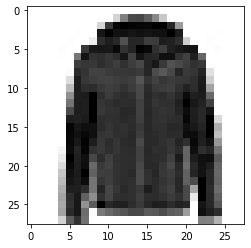

In [3]:
def show_single_image(img_arr):
    plt.imshow(img_arr, cmap="binary")  #热图
    plt.show()

show_single_image(x_train[0])

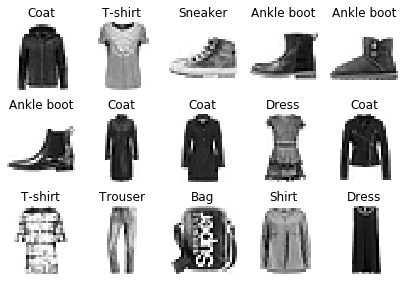

In [4]:
def show_imgs(n_rows, n_cols, x_data, y_data, class_names):
    assert len(x_data) == len(y_data)
    assert n_rows * n_cols < len(x_data)
    plt.figure(figsize = (n_cols * 1.4, n_rows * 1.6))
    for row in range(n_rows):
        for col in range(n_cols):
            index = n_cols * row + col 
            plt.subplot(n_rows, n_cols, index+1)
            plt.imshow(x_data[index], cmap="binary",
                       interpolation = 'nearest')
            plt.axis('off')
            plt.title(class_names[y_data[index]])
    plt.show()

class_names = ['T-shirt', 'Trouser', 'Pullover', 'Dress',
               'Coat', 'Sandal', 'Shirt', 'Sneaker',
               'Bag', 'Ankle boot']
show_imgs(3, 5, x_train, y_train, class_names)

In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
# x_train: [None, 28, 28] -> [None, 784]
x_train_scaled = scaler.fit_transform(
    x_train.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)
x_valid_scaled = scaler.transform(
    x_valid.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)
x_test_scaled = scaler.transform(
    x_test.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)

In [6]:
# tf.keras.models.Sequential()

"""
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))
"""

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation='relu'),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

# relu: y = max(0, x)
# softmax: 将向量变成概率分布. x = [x1, x2, x3], 
#          y = [e^x1/sum, e^x2/sum, e^x3/sum], sum = e^x1 + e^x2 + e^x3

# reason for sparse: y->index. y->one_hot->[] 
model.compile(loss="sparse_categorical_crossentropy",
              optimizer = "sgd",
              metrics = ["accuracy"])

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


In [8]:
#https://tensorflow.google.cn/versions/r2.0/api_docs/python/tf官网的api的tf.keras.callbacks可以看到
# Tensorboard, earlystopping, ModelCheckpoint
#windows下的路径提前创建好callbacks/plugins/profile文件夹
#tensorboard版本不一致问题https://blog.csdn.net/qq_36368388/article/details/89295878按照这个修复就没有问题，
#然后打开localhost:6006
logdir = './callbacks/'
if not os.path.exists(logdir):
    os.mkdir(logdir)
output_model_file = os.path.join(logdir,
                                 "fashion_mnist_model.h5")

callbacks = [
    keras.callbacks.TensorBoard(logdir),
    keras.callbacks.ModelCheckpoint(output_model_file,
                                    save_best_only = True),
    keras.callbacks.EarlyStopping(patience=5, min_delta=1e-3),
]
history = model.fit(x_train_scaled, y_train, epochs=10,
                    validation_data=(x_valid_scaled, y_valid),
                    callbacks=callbacks)

Train on 55000 samples, validate on 5000 samples


Epoch 1/10


   32/55000 [..............................] - ETA: 5:26 - loss: 2.7243 - accuracy: 0.0625

   96/55000 [..............................] - ETA: 2:17 - loss: 2.8059 - accuracy: 0.0938

  480/55000 [..............................] - ETA: 33s - loss: 2.6496 - accuracy: 0.1125 

  704/55000 [..............................] - ETA: 26s - loss: 2.5693 - accuracy: 0.1207

  960/55000 [..............................] - ETA: 22s - loss: 2.5078 - accuracy: 0.1396

 1280/55000 [..............................] - ETA: 19s - loss: 2.4517 - accuracy: 0.1602

 1632/55000 [..............................] - ETA: 16s - loss: 2.3878 - accuracy: 0.1814

 1888/55000 [>.............................] - ETA: 16s - loss: 2.3402 - accuracy: 0.2023

 2080/55000 [>.............................] - ETA: 15s - loss: 2.3068 - accuracy: 0.2135

 2272/55000 [>.............................] - ETA: 15s - loss: 2.2769 - accuracy: 0.2254

 2656/55000 [>.............................] - ETA: 14s - loss: 2.2250 - accuracy: 0.2402

 2944/55000 [>.............................] - ETA: 13s - loss: 2.1838 - accuracy: 0.2558

 3232/55000 [>.............................] - ETA: 13s - loss: 2.1465 - accuracy: 0.2717

 3488/55000 [>.............................] - ETA: 13s - loss: 2.1135 - accuracy: 0.2876

 3776/55000 [=>............................] - ETA: 12s - loss: 2.0819 - accuracy: 0.3006

 3968/55000 [=>............................] - ETA: 12s - loss: 2.0604 - accuracy: 0.3097

 4256/55000 [=>............................] - ETA: 12s - loss: 2.0282 - accuracy: 0.3231

 4608/55000 [=>............................] - ETA: 12s - loss: 1.9945 - accuracy: 0.3359

 4864/55000 [=>............................] - ETA: 11s - loss: 1.9697 - accuracy: 0.3475

 5216/55000 [=>............................] - ETA: 11s - loss: 1.9341 - accuracy: 0.3635

 5536/55000 [==>...........................] - ETA: 11s - loss: 1.9058 - accuracy: 0.3748

 5920/55000 [==>...........................] - ETA: 10s - loss: 1.8674 - accuracy: 0.3900

 6304/55000 [==>...........................] - ETA: 10s - loss: 1.8333 - accuracy: 0.4051

 6656/55000 [==>...........................] - ETA: 10s - loss: 1.8073 - accuracy: 0.4136

 7040/55000 [==>...........................] - ETA: 10s - loss: 1.7786 - accuracy: 0.4266

 7424/55000 [===>..........................] - ETA: 9s - loss: 1.7498 - accuracy: 0.4375 

 7808/55000 [===>..........................] - ETA: 9s - loss: 1.7213 - accuracy: 0.4486

 8032/55000 [===>..........................] - ETA: 9s - loss: 1.7052 - accuracy: 0.4551

 8320/55000 [===>..........................] - ETA: 9s - loss: 1.6868 - accuracy: 0.4614

 8704/55000 [===>..........................] - ETA: 9s - loss: 1.6631 - accuracy: 0.4714

 9152/55000 [===>..........................] - ETA: 9s - loss: 1.6401 - accuracy: 0.4796

 9536/55000 [====>.........................] - ETA: 8s - loss: 1.6188 - accuracy: 0.4867

 9888/55000 [====>.........................] - ETA: 8s - loss: 1.6009 - accuracy: 0.4931

10304/55000 [====>.........................] - ETA: 8s - loss: 1.5785 - accuracy: 0.5003

10720/55000 [====>.........................] - ETA: 8s - loss: 1.5582 - accuracy: 0.5072

11072/55000 [=====>........................] - ETA: 8s - loss: 1.5427 - accuracy: 0.5124

11552/55000 [=====>........................] - ETA: 7s - loss: 1.5213 - accuracy: 0.5197

12096/55000 [=====>........................] - ETA: 7s - loss: 1.4998 - accuracy: 0.5271

12576/55000 [=====>........................] - ETA: 7s - loss: 1.4803 - accuracy: 0.5336

13024/55000 [======>.......................] - ETA: 7s - loss: 1.4633 - accuracy: 0.5388

13504/55000 [======>.......................] - ETA: 7s - loss: 1.4466 - accuracy: 0.5441

13824/55000 [======>.......................] - ETA: 7s - loss: 1.4358 - accuracy: 0.5475

14304/55000 [======>.......................] - ETA: 6s - loss: 1.4194 - accuracy: 0.5536

14848/55000 [=======>......................] - ETA: 6s - loss: 1.4030 - accuracy: 0.5577

15264/55000 [=======>......................] - ETA: 6s - loss: 1.3896 - accuracy: 0.5622

15776/55000 [=======>......................] - ETA: 6s - loss: 1.3752 - accuracy: 0.5666

16256/55000 [=======>......................] - ETA: 6s - loss: 1.3620 - accuracy: 0.5706

16768/55000 [========>.....................] - ETA: 6s - loss: 1.3469 - accuracy: 0.5751

17280/55000 [========>.....................] - ETA: 5s - loss: 1.3326 - accuracy: 0.5792

17696/55000 [========>.....................] - ETA: 5s - loss: 1.3222 - accuracy: 0.5821

18240/55000 [========>.....................] - ETA: 5s - loss: 1.3086 - accuracy: 0.5863

18752/55000 [=========>....................] - ETA: 5s - loss: 1.2963 - accuracy: 0.5899

19264/55000 [=========>....................] - ETA: 5s - loss: 1.2836 - accuracy: 0.5936

19744/55000 [=========>....................] - ETA: 5s - loss: 1.2735 - accuracy: 0.5968

20224/55000 [==========>...................] - ETA: 5s - loss: 1.2629 - accuracy: 0.6003

20704/55000 [==========>...................] - ETA: 5s - loss: 1.2532 - accuracy: 0.6030

21184/55000 [==========>...................] - ETA: 5s - loss: 1.2442 - accuracy: 0.6053

21728/55000 [==========>...................] - ETA: 4s - loss: 1.2340 - accuracy: 0.6084

22272/55000 [===========>..................] - ETA: 4s - loss: 1.2232 - accuracy: 0.6115

22656/55000 [===========>..................] - ETA: 4s - loss: 1.2157 - accuracy: 0.6139

23104/55000 [===========>..................] - ETA: 4s - loss: 1.2080 - accuracy: 0.6160

23616/55000 [===========>..................] - ETA: 4s - loss: 1.1993 - accuracy: 0.6186



24160/55000 [============>.................] - ETA: 4s - loss: 1.1907 - accuracy: 0.6208

24640/55000 [============>.................] - ETA: 4s - loss: 1.1824 - accuracy: 0.6235

25152/55000 [============>.................] - ETA: 4s - loss: 1.1743 - accuracy: 0.6260

25440/55000 [============>.................] - ETA: 4s - loss: 1.1692 - accuracy: 0.6274

25824/55000 [=============>................] - ETA: 4s - loss: 1.1614 - accuracy: 0.6300

26368/55000 [=============>................] - ETA: 4s - loss: 1.1536 - accuracy: 0.6324

26944/55000 [=============>................] - ETA: 3s - loss: 1.1442 - accuracy: 0.6350

27456/55000 [=============>................] - ETA: 3s - loss: 1.1368 - accuracy: 0.6373

27904/55000 [==============>...............] - ETA: 3s - loss: 1.1304 - accuracy: 0.6392

28448/55000 [==============>...............] - ETA: 3s - loss: 1.1229 - accuracy: 0.6417

28992/55000 [==============>...............] - ETA: 3s - loss: 1.1152 - accuracy: 0.6438

29472/55000 [===============>..............] - ETA: 3s - loss: 1.1092 - accuracy: 0.6456

30016/55000 [===============>..............] - ETA: 3s - loss: 1.1046 - accuracy: 0.6465

30464/55000 [===============>..............] - ETA: 3s - loss: 1.1004 - accuracy: 0.6473

31040/55000 [===============>..............] - ETA: 3s - loss: 1.0932 - accuracy: 0.6496

31616/55000 [================>.............] - ETA: 3s - loss: 1.0866 - accuracy: 0.6516

32096/55000 [================>.............] - ETA: 3s - loss: 1.0813 - accuracy: 0.6532

32576/55000 [================>.............] - ETA: 2s - loss: 1.0753 - accuracy: 0.6549

33088/55000 [=================>............] - ETA: 2s - loss: 1.0702 - accuracy: 0.6565

33664/55000 [=================>............] - ETA: 2s - loss: 1.0637 - accuracy: 0.6587

34208/55000 [=================>............] - ETA: 2s - loss: 1.0579 - accuracy: 0.6603



34688/55000 [=================>............] - ETA: 2s - loss: 1.0528 - accuracy: 0.6616

35200/55000 [==================>...........] - ETA: 2s - loss: 1.0482 - accuracy: 0.6626

35712/55000 [==================>...........] - ETA: 2s - loss: 1.0429 - accuracy: 0.6643

36160/55000 [==================>...........] - ETA: 2s - loss: 1.0391 - accuracy: 0.6654

36544/55000 [==================>...........] - ETA: 2s - loss: 1.0356 - accuracy: 0.6664

36928/55000 [===================>..........] - ETA: 2s - loss: 1.0323 - accuracy: 0.6674

37312/55000 [===================>..........] - ETA: 2s - loss: 1.0291 - accuracy: 0.6682

37632/55000 [===================>..........] - ETA: 2s - loss: 1.0262 - accuracy: 0.6691

37920/55000 [===================>..........] - ETA: 2s - loss: 1.0243 - accuracy: 0.6696

38304/55000 [===================>..........] - ETA: 2s - loss: 1.0210 - accuracy: 0.6703

38752/55000 [====================>.........] - ETA: 2s - loss: 1.0171 - accuracy: 0.6714

39104/55000 [====================>.........] - ETA: 2s - loss: 1.0138 - accuracy: 0.6725

39520/55000 [====================>.........] - ETA: 2s - loss: 1.0101 - accuracy: 0.6737

39872/55000 [====================>.........] - ETA: 1s - loss: 1.0079 - accuracy: 0.6743

40256/55000 [====================>.........] - ETA: 1s - loss: 1.0047 - accuracy: 0.6754

40672/55000 [=====================>........] - ETA: 1s - loss: 1.0018 - accuracy: 0.6761

41056/55000 [=====================>........] - ETA: 1s - loss: 0.9986 - accuracy: 0.6769

41440/55000 [=====================>........] - ETA: 1s - loss: 0.9959 - accuracy: 0.6777

41824/55000 [=====================>........] - ETA: 1s - loss: 0.9933 - accuracy: 0.6786

42240/55000 [======================>.......] - ETA: 1s - loss: 0.9906 - accuracy: 0.6793

42656/55000 [======================>.......] - ETA: 1s - loss: 0.9875 - accuracy: 0.6800

43104/55000 [======================>.......] - ETA: 1s - loss: 0.9841 - accuracy: 0.6808

43552/55000 [======================>.......] - ETA: 1s - loss: 0.9805 - accuracy: 0.6817

43840/55000 [======================>.......] - ETA: 1s - loss: 0.9784 - accuracy: 0.6823



44224/55000 [=======================>......] - ETA: 1s - loss: 0.9764 - accuracy: 0.6828

44576/55000 [=======================>......] - ETA: 1s - loss: 0.9743 - accuracy: 0.6835

44896/55000 [=======================>......] - ETA: 1s - loss: 0.9727 - accuracy: 0.6836

45376/55000 [=======================>......] - ETA: 1s - loss: 0.9691 - accuracy: 0.6847

45760/55000 [=======================>......] - ETA: 1s - loss: 0.9658 - accuracy: 0.6857

46176/55000 [========================>.....] - ETA: 1s - loss: 0.9629 - accuracy: 0.6865

46592/55000 [========================>.....] - ETA: 1s - loss: 0.9599 - accuracy: 0.6874

47040/55000 [========================>.....] - ETA: 1s - loss: 0.9577 - accuracy: 0.6878

47424/55000 [========================>.....] - ETA: 0s - loss: 0.9549 - accuracy: 0.6887

47808/55000 [=========================>....] - ETA: 0s - loss: 0.9524 - accuracy: 0.6894

48192/55000 [=========================>....] - ETA: 0s - loss: 0.9499 - accuracy: 0.6903

48544/55000 [=========================>....] - ETA: 0s - loss: 0.9474 - accuracy: 0.6910

48896/55000 [=========================>....] - ETA: 0s - loss: 0.9447 - accuracy: 0.6918



49248/55000 [=========================>....] - ETA: 0s - loss: 0.9430 - accuracy: 0.6922

49568/55000 [==========================>...] - ETA: 0s - loss: 0.9410 - accuracy: 0.6929

49952/55000 [==========================>...] - ETA: 0s - loss: 0.9385 - accuracy: 0.6935

50368/55000 [==========================>...] - ETA: 0s - loss: 0.9363 - accuracy: 0.6941

50784/55000 [==========================>...] - ETA: 0s - loss: 0.9341 - accuracy: 0.6949

51104/55000 [==========================>...] - ETA: 0s - loss: 0.9324 - accuracy: 0.6952

51360/55000 [===========================>..] - ETA: 0s - loss: 0.9312 - accuracy: 0.6955

51616/55000 [===========================>..] - ETA: 0s - loss: 0.9298 - accuracy: 0.6959

52000/55000 [===========================>..] - ETA: 0s - loss: 0.9277 - accuracy: 0.6966

52448/55000 [===========================>..] - ETA: 0s - loss: 0.9256 - accuracy: 0.6970

52864/55000 [===========================>..] - ETA: 0s - loss: 0.9232 - accuracy: 0.6976

53088/55000 [===========================>..] - ETA: 0s - loss: 0.9218 - accuracy: 0.6981

53344/55000 [============================>.] - ETA: 0s - loss: 0.9203 - accuracy: 0.6985

53664/55000 [============================>.] - ETA: 0s - loss: 0.9182 - accuracy: 0.6992

53888/55000 [============================>.] - ETA: 0s - loss: 0.9171 - accuracy: 0.6995

54048/55000 [============================>.] - ETA: 0s - loss: 0.9168 - accuracy: 0.6995

54304/55000 [============================>.] - ETA: 0s - loss: 0.9155 - accuracy: 0.7000

54496/55000 [============================>.] - ETA: 0s - loss: 0.9144 - accuracy: 0.7003

54720/55000 [============================>.] - ETA: 0s - loss: 0.9129 - accuracy: 0.7007

54976/55000 [============================>.] - ETA: 0s - loss: 0.9112 - accuracy: 0.7013

55000/55000 [==============================] - 8s 147us/sample - loss: 0.9111 - accuracy: 0.7014 - val_loss: 0.6095 - val_accuracy: 0.7938


Epoch 2/10
   32/55000 [..............................] - ETA: 2:41 - loss: 0.6520 - accuracy: 0.7812

  320/55000 [..............................] - ETA: 24s - loss: 0.5865 - accuracy: 0.7906 



  704/55000 [..............................] - ETA: 15s - loss: 0.6168 - accuracy: 0.7756

  928/55000 [..............................] - ETA: 14s - loss: 0.6226 - accuracy: 0.7748

 1248/55000 [..............................] - ETA: 13s - loss: 0.6110 - accuracy: 0.7772

 1632/55000 [..............................] - ETA: 11s - loss: 0.6185 - accuracy: 0.7794

 1952/55000 [>.............................] - ETA: 11s - loss: 0.6206 - accuracy: 0.7772

 2432/55000 [>.............................] - ETA: 10s - loss: 0.6260 - accuracy: 0.7784

 2848/55000 [>.............................] - ETA: 9s - loss: 0.6222 - accuracy: 0.7816 

 3200/55000 [>.............................] - ETA: 9s - loss: 0.6259 - accuracy: 0.7797

 3552/55000 [>.............................] - ETA: 8s - loss: 0.6275 - accuracy: 0.7804

 3904/55000 [=>............................] - ETA: 8s - loss: 0.6259 - accuracy: 0.7830

 4224/55000 [=>............................] - ETA: 8s - loss: 0.6229 - accuracy: 0.7841

 4704/55000 [=>............................] - ETA: 8s - loss: 0.6260 - accuracy: 0.7806

 5088/55000 [=>............................] - ETA: 8s - loss: 0.6219 - accuracy: 0.7824

 5344/55000 [=>............................] - ETA: 8s - loss: 0.6211 - accuracy: 0.7827

 5728/55000 [==>...........................] - ETA: 8s - loss: 0.6255 - accuracy: 0.7821

 6176/55000 [==>...........................] - ETA: 7s - loss: 0.6216 - accuracy: 0.7832

 6528/55000 [==>...........................] - ETA: 7s - loss: 0.6159 - accuracy: 0.7849

 6848/55000 [==>...........................] - ETA: 7s - loss: 0.6170 - accuracy: 0.7843

 7200/55000 [==>...........................] - ETA: 7s - loss: 0.6169 - accuracy: 0.7850

 7616/55000 [===>..........................] - ETA: 7s - loss: 0.6176 - accuracy: 0.7844

 8000/55000 [===>..........................] - ETA: 7s - loss: 0.6137 - accuracy: 0.7853

 8416/55000 [===>..........................] - ETA: 7s - loss: 0.6151 - accuracy: 0.7860

 8800/55000 [===>..........................] - ETA: 7s - loss: 0.6186 - accuracy: 0.7853

 9216/55000 [====>.........................] - ETA: 6s - loss: 0.6174 - accuracy: 0.7857

 9600/55000 [====>.........................] - ETA: 6s - loss: 0.6141 - accuracy: 0.7870

10016/55000 [====>.........................] - ETA: 6s - loss: 0.6130 - accuracy: 0.7867

10400/55000 [====>.........................] - ETA: 6s - loss: 0.6120 - accuracy: 0.7874

10784/55000 [====>.........................] - ETA: 6s - loss: 0.6128 - accuracy: 0.7876

11232/55000 [=====>........................] - ETA: 6s - loss: 0.6136 - accuracy: 0.7870

11552/55000 [=====>........................] - ETA: 6s - loss: 0.6142 - accuracy: 0.7865

11808/55000 [=====>........................] - ETA: 6s - loss: 0.6153 - accuracy: 0.7866

12128/55000 [=====>........................] - ETA: 6s - loss: 0.6162 - accuracy: 0.7856

12384/55000 [=====>........................] - ETA: 6s - loss: 0.6164 - accuracy: 0.7853

12608/55000 [=====>........................] - ETA: 6s - loss: 0.6152 - accuracy: 0.7858

12928/55000 [======>.......................] - ETA: 6s - loss: 0.6145 - accuracy: 0.7860

13216/55000 [======>.......................] - ETA: 6s - loss: 0.6142 - accuracy: 0.7864

13536/55000 [======>.......................] - ETA: 6s - loss: 0.6153 - accuracy: 0.7863

13920/55000 [======>.......................] - ETA: 6s - loss: 0.6150 - accuracy: 0.7865



14272/55000 [======>.......................] - ETA: 6s - loss: 0.6147 - accuracy: 0.7862

14656/55000 [======>.......................] - ETA: 6s - loss: 0.6153 - accuracy: 0.7858

14912/55000 [=======>......................] - ETA: 6s - loss: 0.6158 - accuracy: 0.7852

15136/55000 [=======>......................] - ETA: 6s - loss: 0.6152 - accuracy: 0.7854

15488/55000 [=======>......................] - ETA: 6s - loss: 0.6142 - accuracy: 0.7863

15840/55000 [=======>......................] - ETA: 6s - loss: 0.6139 - accuracy: 0.7864

16288/55000 [=======>......................] - ETA: 6s - loss: 0.6134 - accuracy: 0.7861

16704/55000 [========>.....................] - ETA: 5s - loss: 0.6134 - accuracy: 0.7857

17024/55000 [========>.....................] - ETA: 5s - loss: 0.6122 - accuracy: 0.7861

17408/55000 [========>.....................] - ETA: 5s - loss: 0.6117 - accuracy: 0.7862

17824/55000 [========>.....................] - ETA: 5s - loss: 0.6108 - accuracy: 0.7867

18176/55000 [========>.....................] - ETA: 5s - loss: 0.6115 - accuracy: 0.7869

18624/55000 [=========>....................] - ETA: 5s - loss: 0.6107 - accuracy: 0.7875

18976/55000 [=========>....................] - ETA: 5s - loss: 0.6112 - accuracy: 0.7873



19424/55000 [=========>....................] - ETA: 5s - loss: 0.6106 - accuracy: 0.7877

19872/55000 [=========>....................] - ETA: 5s - loss: 0.6092 - accuracy: 0.7883

20224/55000 [==========>...................] - ETA: 5s - loss: 0.6088 - accuracy: 0.7884

20640/55000 [==========>...................] - ETA: 5s - loss: 0.6086 - accuracy: 0.7880

21056/55000 [==========>...................] - ETA: 5s - loss: 0.6088 - accuracy: 0.7878

21472/55000 [==========>...................] - ETA: 5s - loss: 0.6082 - accuracy: 0.7885

21760/55000 [==========>...................] - ETA: 5s - loss: 0.6085 - accuracy: 0.7879

22048/55000 [===========>..................] - ETA: 4s - loss: 0.6084 - accuracy: 0.7881

22432/55000 [===========>..................] - ETA: 4s - loss: 0.6090 - accuracy: 0.7878

22848/55000 [===========>..................] - ETA: 4s - loss: 0.6080 - accuracy: 0.7881

23296/55000 [===========>..................] - ETA: 4s - loss: 0.6079 - accuracy: 0.7880

23744/55000 [===========>..................] - ETA: 4s - loss: 0.6058 - accuracy: 0.7894

24096/55000 [============>.................] - ETA: 4s - loss: 0.6054 - accuracy: 0.7896

24512/55000 [============>.................] - ETA: 4s - loss: 0.6062 - accuracy: 0.7894

24928/55000 [============>.................] - ETA: 4s - loss: 0.6045 - accuracy: 0.7898

25376/55000 [============>.................] - ETA: 4s - loss: 0.6029 - accuracy: 0.7903

25696/55000 [=============>................] - ETA: 4s - loss: 0.6022 - accuracy: 0.7903

26080/55000 [=============>................] - ETA: 4s - loss: 0.6021 - accuracy: 0.7901

26432/55000 [=============>................] - ETA: 4s - loss: 0.6011 - accuracy: 0.7904

26752/55000 [=============>................] - ETA: 4s - loss: 0.6009 - accuracy: 0.7907

27072/55000 [=============>................] - ETA: 4s - loss: 0.6010 - accuracy: 0.7907

27488/55000 [=============>................] - ETA: 4s - loss: 0.5998 - accuracy: 0.7910

27904/55000 [==============>...............] - ETA: 4s - loss: 0.5988 - accuracy: 0.7912

28224/55000 [==============>...............] - ETA: 3s - loss: 0.5983 - accuracy: 0.7917

28608/55000 [==============>...............] - ETA: 3s - loss: 0.5971 - accuracy: 0.7921

28992/55000 [==============>...............] - ETA: 3s - loss: 0.5967 - accuracy: 0.7923

29344/55000 [===============>..............] - ETA: 3s - loss: 0.5965 - accuracy: 0.7922

29760/55000 [===============>..............] - ETA: 3s - loss: 0.5953 - accuracy: 0.7924

29984/55000 [===============>..............] - ETA: 3s - loss: 0.5947 - accuracy: 0.7925

30304/55000 [===============>..............] - ETA: 3s - loss: 0.5938 - accuracy: 0.7929

30560/55000 [===============>..............] - ETA: 3s - loss: 0.5937 - accuracy: 0.7931

30784/55000 [===============>..............] - ETA: 3s - loss: 0.5933 - accuracy: 0.7932

31040/55000 [===============>..............] - ETA: 3s - loss: 0.5928 - accuracy: 0.7933

31232/55000 [================>.............] - ETA: 3s - loss: 0.5927 - accuracy: 0.7933



31424/55000 [================>.............] - ETA: 3s - loss: 0.5923 - accuracy: 0.7933

31616/55000 [================>.............] - ETA: 3s - loss: 0.5926 - accuracy: 0.7936

31936/55000 [================>.............] - ETA: 3s - loss: 0.5926 - accuracy: 0.7936

32160/55000 [================>.............] - ETA: 3s - loss: 0.5924 - accuracy: 0.7935

32576/55000 [================>.............] - ETA: 3s - loss: 0.5921 - accuracy: 0.7936

32960/55000 [================>.............] - ETA: 3s - loss: 0.5926 - accuracy: 0.7933

33344/55000 [=================>............] - ETA: 3s - loss: 0.5923 - accuracy: 0.7932

33792/55000 [=================>............] - ETA: 3s - loss: 0.5916 - accuracy: 0.7936

34144/55000 [=================>............] - ETA: 3s - loss: 0.5913 - accuracy: 0.7934

34528/55000 [=================>............] - ETA: 3s - loss: 0.5906 - accuracy: 0.7936



34976/55000 [==================>...........] - ETA: 3s - loss: 0.5904 - accuracy: 0.7936

35424/55000 [==================>...........] - ETA: 2s - loss: 0.5903 - accuracy: 0.7935

35840/55000 [==================>...........] - ETA: 2s - loss: 0.5901 - accuracy: 0.7936

36224/55000 [==================>...........] - ETA: 2s - loss: 0.5899 - accuracy: 0.7937

36608/55000 [==================>...........] - ETA: 2s - loss: 0.5890 - accuracy: 0.7940

36960/55000 [===================>..........] - ETA: 2s - loss: 0.5882 - accuracy: 0.7945

37312/55000 [===================>..........] - ETA: 2s - loss: 0.5879 - accuracy: 0.7946

37696/55000 [===================>..........] - ETA: 2s - loss: 0.5877 - accuracy: 0.7947

38080/55000 [===================>..........] - ETA: 2s - loss: 0.5870 - accuracy: 0.7947

38528/55000 [====================>.........] - ETA: 2s - loss: 0.5871 - accuracy: 0.7946

38816/55000 [====================>.........] - ETA: 2s - loss: 0.5868 - accuracy: 0.7948

39200/55000 [====================>.........] - ETA: 2s - loss: 0.5863 - accuracy: 0.7948

39616/55000 [====================>.........] - ETA: 2s - loss: 0.5853 - accuracy: 0.7951



39968/55000 [====================>.........] - ETA: 2s - loss: 0.5852 - accuracy: 0.7950

40416/55000 [=====================>........] - ETA: 2s - loss: 0.5850 - accuracy: 0.7950

40736/55000 [=====================>........] - ETA: 2s - loss: 0.5850 - accuracy: 0.7951

41120/55000 [=====================>........] - ETA: 2s - loss: 0.5848 - accuracy: 0.7954

41504/55000 [=====================>........] - ETA: 2s - loss: 0.5846 - accuracy: 0.7955

41856/55000 [=====================>........] - ETA: 1s - loss: 0.5846 - accuracy: 0.7954

42272/55000 [======================>.......] - ETA: 1s - loss: 0.5842 - accuracy: 0.7954

42624/55000 [======================>.......] - ETA: 1s - loss: 0.5841 - accuracy: 0.7953

43040/55000 [======================>.......] - ETA: 1s - loss: 0.5838 - accuracy: 0.7957

43456/55000 [======================>.......] - ETA: 1s - loss: 0.5835 - accuracy: 0.7959

43904/55000 [======================>.......] - ETA: 1s - loss: 0.5830 - accuracy: 0.7960

44352/55000 [=======================>......] - ETA: 1s - loss: 0.5825 - accuracy: 0.7963

44736/55000 [=======================>......] - ETA: 1s - loss: 0.5815 - accuracy: 0.7969

45184/55000 [=======================>......] - ETA: 1s - loss: 0.5817 - accuracy: 0.7968

45600/55000 [=======================>......] - ETA: 1s - loss: 0.5812 - accuracy: 0.7969

45984/55000 [========================>.....] - ETA: 1s - loss: 0.5809 - accuracy: 0.7969

46336/55000 [========================>.....] - ETA: 1s - loss: 0.5801 - accuracy: 0.7971

46784/55000 [========================>.....] - ETA: 1s - loss: 0.5794 - accuracy: 0.7974

47200/55000 [========================>.....] - ETA: 1s - loss: 0.5794 - accuracy: 0.7975

47552/55000 [========================>.....] - ETA: 1s - loss: 0.5794 - accuracy: 0.7975

47904/55000 [=========================>....] - ETA: 1s - loss: 0.5793 - accuracy: 0.7975

48352/55000 [=========================>....] - ETA: 0s - loss: 0.5792 - accuracy: 0.7974

48768/55000 [=========================>....] - ETA: 0s - loss: 0.5788 - accuracy: 0.7975

49216/55000 [=========================>....] - ETA: 0s - loss: 0.5788 - accuracy: 0.7976

49664/55000 [==========================>...] - ETA: 0s - loss: 0.5792 - accuracy: 0.7977

50048/55000 [==========================>...] - ETA: 0s - loss: 0.5789 - accuracy: 0.7977

50336/55000 [==========================>...] - ETA: 0s - loss: 0.5788 - accuracy: 0.7978

50656/55000 [==========================>...] - ETA: 0s - loss: 0.5786 - accuracy: 0.7979

51104/55000 [==========================>...] - ETA: 0s - loss: 0.5783 - accuracy: 0.7979

51424/55000 [===========================>..] - ETA: 0s - loss: 0.5782 - accuracy: 0.7981

51840/55000 [===========================>..] - ETA: 0s - loss: 0.5780 - accuracy: 0.7982

52096/55000 [===========================>..] - ETA: 0s - loss: 0.5778 - accuracy: 0.7983

52512/55000 [===========================>..] - ETA: 0s - loss: 0.5773 - accuracy: 0.7985

52928/55000 [===========================>..] - ETA: 0s - loss: 0.5775 - accuracy: 0.7985

53344/55000 [============================>.] - ETA: 0s - loss: 0.5771 - accuracy: 0.7986

53760/55000 [============================>.] - ETA: 0s - loss: 0.5769 - accuracy: 0.7988

54112/55000 [============================>.] - ETA: 0s - loss: 0.5769 - accuracy: 0.7987

54496/55000 [============================>.] - ETA: 0s - loss: 0.5764 - accuracy: 0.7989

54880/55000 [============================>.] - ETA: 0s - loss: 0.5765 - accuracy: 0.7987

55000/55000 [==============================] - 8s 152us/sample - loss: 0.5762 - accuracy: 0.7988 - val_loss: 0.5192 - val_accuracy: 0.8216


Epoch 3/10
   32/55000 [..............................] - ETA: 20s - loss: 0.5964 - accuracy: 0.7812

  384/55000 [..............................] - ETA: 9s - loss: 0.5578 - accuracy: 0.8411 

  800/55000 [..............................] - ETA: 7s - loss: 0.5534 - accuracy: 0.8150



 1184/55000 [..............................] - ETA: 7s - loss: 0.5664 - accuracy: 0.8074

 1600/55000 [..............................] - ETA: 7s - loss: 0.5454 - accuracy: 0.8112

 1984/55000 [>.............................] - ETA: 7s - loss: 0.5490 - accuracy: 0.8095

 2272/55000 [>.............................] - ETA: 7s - loss: 0.5423 - accuracy: 0.8138

 2624/55000 [>.............................] - ETA: 7s - loss: 0.5402 - accuracy: 0.8121

 3008/55000 [>.............................] - ETA: 7s - loss: 0.5432 - accuracy: 0.8102

 3296/55000 [>.............................] - ETA: 7s - loss: 0.5414 - accuracy: 0.8104

 3712/55000 [=>............................] - ETA: 7s - loss: 0.5361 - accuracy: 0.8125

 4128/55000 [=>............................] - ETA: 7s - loss: 0.5323 - accuracy: 0.8135



 4608/55000 [=>............................] - ETA: 6s - loss: 0.5345 - accuracy: 0.8112

 5152/55000 [=>............................] - ETA: 6s - loss: 0.5295 - accuracy: 0.8127

 5664/55000 [==>...........................] - ETA: 6s - loss: 0.5364 - accuracy: 0.8097

 6048/55000 [==>...........................] - ETA: 6s - loss: 0.5352 - accuracy: 0.8115

 6528/55000 [==>...........................] - ETA: 6s - loss: 0.5356 - accuracy: 0.8128

 7072/55000 [==>...........................] - ETA: 6s - loss: 0.5379 - accuracy: 0.8119

 7584/55000 [===>..........................] - ETA: 5s - loss: 0.5381 - accuracy: 0.8126

 8064/55000 [===>..........................] - ETA: 5s - loss: 0.5354 - accuracy: 0.8134

 8576/55000 [===>..........................] - ETA: 5s - loss: 0.5326 - accuracy: 0.8138

 9120/55000 [===>..........................] - ETA: 5s - loss: 0.5336 - accuracy: 0.8141

 9568/55000 [====>.........................] - ETA: 5s - loss: 0.5339 - accuracy: 0.8136

 9920/55000 [====>.........................] - ETA: 5s - loss: 0.5320 - accuracy: 0.8145

10368/55000 [====>.........................] - ETA: 5s - loss: 0.5318 - accuracy: 0.8141

10720/55000 [====>.........................] - ETA: 5s - loss: 0.5308 - accuracy: 0.8148

11136/55000 [=====>........................] - ETA: 5s - loss: 0.5320 - accuracy: 0.8138

11520/55000 [=====>........................] - ETA: 5s - loss: 0.5304 - accuracy: 0.8144

11872/55000 [=====>........................] - ETA: 5s - loss: 0.5288 - accuracy: 0.8148

12224/55000 [=====>........................] - ETA: 5s - loss: 0.5285 - accuracy: 0.8150

12640/55000 [=====>........................] - ETA: 5s - loss: 0.5292 - accuracy: 0.8145

13184/55000 [======>.......................] - ETA: 5s - loss: 0.5274 - accuracy: 0.8151

13600/55000 [======>.......................] - ETA: 5s - loss: 0.5291 - accuracy: 0.8137

14144/55000 [======>.......................] - ETA: 4s - loss: 0.5270 - accuracy: 0.8147

14656/55000 [======>.......................] - ETA: 4s - loss: 0.5259 - accuracy: 0.8154

15200/55000 [=======>......................] - ETA: 4s - loss: 0.5255 - accuracy: 0.8148

15776/55000 [=======>......................] - ETA: 4s - loss: 0.5259 - accuracy: 0.8143

16256/55000 [=======>......................] - ETA: 4s - loss: 0.5272 - accuracy: 0.8137

16768/55000 [========>.....................] - ETA: 4s - loss: 0.5278 - accuracy: 0.8134

17248/55000 [========>.....................] - ETA: 4s - loss: 0.5263 - accuracy: 0.8130

17760/55000 [========>.....................] - ETA: 4s - loss: 0.5256 - accuracy: 0.8128

18304/55000 [========>.....................] - ETA: 4s - loss: 0.5263 - accuracy: 0.8130

18784/55000 [=========>....................] - ETA: 4s - loss: 0.5256 - accuracy: 0.8133

19296/55000 [=========>....................] - ETA: 4s - loss: 0.5253 - accuracy: 0.8136

19840/55000 [=========>....................] - ETA: 4s - loss: 0.5257 - accuracy: 0.8135

20384/55000 [==========>...................] - ETA: 3s - loss: 0.5238 - accuracy: 0.8143

20832/55000 [==========>...................] - ETA: 3s - loss: 0.5236 - accuracy: 0.8144

21376/55000 [==========>...................] - ETA: 3s - loss: 0.5227 - accuracy: 0.8148

21856/55000 [==========>...................] - ETA: 3s - loss: 0.5220 - accuracy: 0.8155

22400/55000 [===========>..................] - ETA: 3s - loss: 0.5213 - accuracy: 0.8157

22944/55000 [===========>..................] - ETA: 3s - loss: 0.5195 - accuracy: 0.8164

23456/55000 [===========>..................] - ETA: 3s - loss: 0.5205 - accuracy: 0.8159

23936/55000 [============>.................] - ETA: 3s - loss: 0.5195 - accuracy: 0.8159

24448/55000 [============>.................] - ETA: 3s - loss: 0.5196 - accuracy: 0.8157

24768/55000 [============>.................] - ETA: 3s - loss: 0.5185 - accuracy: 0.8161

25312/55000 [============>.................] - ETA: 3s - loss: 0.5185 - accuracy: 0.8161

25824/55000 [=============>................] - ETA: 3s - loss: 0.5193 - accuracy: 0.8159



26336/55000 [=============>................] - ETA: 3s - loss: 0.5196 - accuracy: 0.8159

26784/55000 [=============>................] - ETA: 3s - loss: 0.5200 - accuracy: 0.8155

27328/55000 [=============>................] - ETA: 3s - loss: 0.5213 - accuracy: 0.8152

27840/55000 [==============>...............] - ETA: 3s - loss: 0.5220 - accuracy: 0.8149

28320/55000 [==============>...............] - ETA: 2s - loss: 0.5213 - accuracy: 0.8153

28832/55000 [==============>...............] - ETA: 2s - loss: 0.5216 - accuracy: 0.8157

29376/55000 [===============>..............] - ETA: 2s - loss: 0.5225 - accuracy: 0.8155

29824/55000 [===============>..............] - ETA: 2s - loss: 0.5218 - accuracy: 0.8156

30272/55000 [===============>..............] - ETA: 2s - loss: 0.5206 - accuracy: 0.8160

30816/55000 [===============>..............] - ETA: 2s - loss: 0.5215 - accuracy: 0.8158

31392/55000 [================>.............] - ETA: 2s - loss: 0.5218 - accuracy: 0.8157

31904/55000 [================>.............] - ETA: 2s - loss: 0.5220 - accuracy: 0.8151

32384/55000 [================>.............] - ETA: 2s - loss: 0.5218 - accuracy: 0.8152

32928/55000 [================>.............] - ETA: 2s - loss: 0.5218 - accuracy: 0.8155

33408/55000 [=================>............] - ETA: 2s - loss: 0.5211 - accuracy: 0.8158

34016/55000 [=================>............] - ETA: 2s - loss: 0.5210 - accuracy: 0.8158

34528/55000 [=================>............] - ETA: 2s - loss: 0.5211 - accuracy: 0.8157

35008/55000 [==================>...........] - ETA: 2s - loss: 0.5216 - accuracy: 0.8157

35488/55000 [==================>...........] - ETA: 2s - loss: 0.5217 - accuracy: 0.8156

36000/55000 [==================>...........] - ETA: 2s - loss: 0.5214 - accuracy: 0.8157



36544/55000 [==================>...........] - ETA: 2s - loss: 0.5212 - accuracy: 0.8157

37056/55000 [===================>..........] - ETA: 1s - loss: 0.5211 - accuracy: 0.8160

37536/55000 [===================>..........] - ETA: 1s - loss: 0.5202 - accuracy: 0.8165

37984/55000 [===================>..........] - ETA: 1s - loss: 0.5201 - accuracy: 0.8166

38464/55000 [===================>..........] - ETA: 1s - loss: 0.5200 - accuracy: 0.8167

38976/55000 [====================>.........] - ETA: 1s - loss: 0.5203 - accuracy: 0.8167

39520/55000 [====================>.........] - ETA: 1s - loss: 0.5193 - accuracy: 0.8170



40064/55000 [====================>.........] - ETA: 1s - loss: 0.5196 - accuracy: 0.8170

40608/55000 [=====================>........] - ETA: 1s - loss: 0.5187 - accuracy: 0.8172

41152/55000 [=====================>........] - ETA: 1s - loss: 0.5186 - accuracy: 0.8173

41632/55000 [=====================>........] - ETA: 1s - loss: 0.5186 - accuracy: 0.8172

42016/55000 [=====================>........] - ETA: 1s - loss: 0.5178 - accuracy: 0.8176

42528/55000 [======================>.......] - ETA: 1s - loss: 0.5178 - accuracy: 0.8177

43040/55000 [======================>.......] - ETA: 1s - loss: 0.5174 - accuracy: 0.8180

43584/55000 [======================>.......] - ETA: 1s - loss: 0.5171 - accuracy: 0.8180

44128/55000 [=======================>......] - ETA: 1s - loss: 0.5168 - accuracy: 0.8181

44640/55000 [=======================>......] - ETA: 1s - loss: 0.5168 - accuracy: 0.8181

45152/55000 [=======================>......] - ETA: 1s - loss: 0.5165 - accuracy: 0.8183

45664/55000 [=======================>......] - ETA: 1s - loss: 0.5159 - accuracy: 0.8186

46144/55000 [========================>.....] - ETA: 0s - loss: 0.5161 - accuracy: 0.8183

46720/55000 [========================>.....] - ETA: 0s - loss: 0.5161 - accuracy: 0.8183

47264/55000 [========================>.....] - ETA: 0s - loss: 0.5154 - accuracy: 0.8186

47808/55000 [=========================>....] - ETA: 0s - loss: 0.5149 - accuracy: 0.8187

48256/55000 [=========================>....] - ETA: 0s - loss: 0.5145 - accuracy: 0.8187

48736/55000 [=========================>....] - ETA: 0s - loss: 0.5139 - accuracy: 0.8189

49248/55000 [=========================>....] - ETA: 0s - loss: 0.5140 - accuracy: 0.8187

49824/55000 [==========================>...] - ETA: 0s - loss: 0.5143 - accuracy: 0.8186

50336/55000 [==========================>...] - ETA: 0s - loss: 0.5139 - accuracy: 0.8187

50816/55000 [==========================>...] - ETA: 0s - loss: 0.5142 - accuracy: 0.8186

51296/55000 [==========================>...] - ETA: 0s - loss: 0.5140 - accuracy: 0.8188

51840/55000 [===========================>..] - ETA: 0s - loss: 0.5143 - accuracy: 0.8185

52448/55000 [===========================>..] - ETA: 0s - loss: 0.5142 - accuracy: 0.8184

52960/55000 [===========================>..] - ETA: 0s - loss: 0.5142 - accuracy: 0.8184

53440/55000 [============================>.] - ETA: 0s - loss: 0.5142 - accuracy: 0.8182

53856/55000 [============================>.] - ETA: 0s - loss: 0.5139 - accuracy: 0.8184

54240/55000 [============================>.] - ETA: 0s - loss: 0.5142 - accuracy: 0.8184

54752/55000 [============================>.] - ETA: 0s - loss: 0.5137 - accuracy: 0.8187

55000/55000 [==============================] - 6s 113us/sample - loss: 0.5136 - accuracy: 0.8187 - val_loss: 0.4796 - val_accuracy: 0.8340


Epoch 4/10
   32/55000 [..............................] - ETA: 15s - loss: 0.8727 - accuracy: 0.8125

  544/55000 [..............................] - ETA: 6s - loss: 0.5345 - accuracy: 0.8327 

 1024/55000 [..............................] - ETA: 5s - loss: 0.5085 - accuracy: 0.8330

 1568/55000 [..............................] - ETA: 5s - loss: 0.4946 - accuracy: 0.8310

 2112/55000 [>.............................] - ETA: 5s - loss: 0.4925 - accuracy: 0.8286

 2656/55000 [>.............................] - ETA: 5s - loss: 0.4730 - accuracy: 0.8366

 3200/55000 [>.............................] - ETA: 5s - loss: 0.4805 - accuracy: 0.8309

 3680/55000 [=>............................] - ETA: 5s - loss: 0.4762 - accuracy: 0.8332

 4192/55000 [=>............................] - ETA: 5s - loss: 0.4770 - accuracy: 0.8335

 4672/55000 [=>............................] - ETA: 5s - loss: 0.4778 - accuracy: 0.8330

 5184/55000 [=>............................] - ETA: 5s - loss: 0.4787 - accuracy: 0.8322

 5728/55000 [==>...........................] - ETA: 4s - loss: 0.4794 - accuracy: 0.8312

 6304/55000 [==>...........................] - ETA: 4s - loss: 0.4792 - accuracy: 0.8319

 6848/55000 [==>...........................] - ETA: 4s - loss: 0.4829 - accuracy: 0.8322

 7328/55000 [==>...........................] - ETA: 4s - loss: 0.4842 - accuracy: 0.8315

 7872/55000 [===>..........................] - ETA: 4s - loss: 0.4812 - accuracy: 0.8328

 8352/55000 [===>..........................] - ETA: 4s - loss: 0.4808 - accuracy: 0.8314

 8896/55000 [===>..........................] - ETA: 4s - loss: 0.4845 - accuracy: 0.8298

 9408/55000 [====>.........................] - ETA: 4s - loss: 0.4859 - accuracy: 0.8304

 9856/55000 [====>.........................] - ETA: 4s - loss: 0.4853 - accuracy: 0.8313



10368/55000 [====>.........................] - ETA: 4s - loss: 0.4868 - accuracy: 0.8311

10912/55000 [====>.........................] - ETA: 4s - loss: 0.4875 - accuracy: 0.8306

11456/55000 [=====>........................] - ETA: 4s - loss: 0.4909 - accuracy: 0.8295

11968/55000 [=====>........................] - ETA: 4s - loss: 0.4913 - accuracy: 0.8290

12480/55000 [=====>........................] - ETA: 4s - loss: 0.4898 - accuracy: 0.8293

12960/55000 [======>.......................] - ETA: 4s - loss: 0.4896 - accuracy: 0.8294

13440/55000 [======>.......................] - ETA: 4s - loss: 0.4907 - accuracy: 0.8292



13920/55000 [======>.......................] - ETA: 4s - loss: 0.4905 - accuracy: 0.8293

14400/55000 [======>.......................] - ETA: 4s - loss: 0.4884 - accuracy: 0.8305

14944/55000 [=======>......................] - ETA: 4s - loss: 0.4891 - accuracy: 0.8294

15424/55000 [=======>......................] - ETA: 3s - loss: 0.4883 - accuracy: 0.8296

15968/55000 [=======>......................] - ETA: 3s - loss: 0.4870 - accuracy: 0.8302

16416/55000 [=======>......................] - ETA: 3s - loss: 0.4901 - accuracy: 0.8296

16896/55000 [========>.....................] - ETA: 3s - loss: 0.4885 - accuracy: 0.8297

17408/55000 [========>.....................] - ETA: 3s - loss: 0.4888 - accuracy: 0.8298

17952/55000 [========>.....................] - ETA: 3s - loss: 0.4897 - accuracy: 0.8296

18528/55000 [=========>....................] - ETA: 3s - loss: 0.4921 - accuracy: 0.8287

19008/55000 [=========>....................] - ETA: 3s - loss: 0.4920 - accuracy: 0.8288

19520/55000 [=========>....................] - ETA: 3s - loss: 0.4902 - accuracy: 0.8297

20000/55000 [=========>....................] - ETA: 3s - loss: 0.4902 - accuracy: 0.8295

20480/55000 [==========>...................] - ETA: 3s - loss: 0.4895 - accuracy: 0.8301

21024/55000 [==========>...................] - ETA: 3s - loss: 0.4891 - accuracy: 0.8301

21504/55000 [==========>...................] - ETA: 3s - loss: 0.4893 - accuracy: 0.8298

22016/55000 [===========>..................] - ETA: 3s - loss: 0.4893 - accuracy: 0.8291

22528/55000 [===========>..................] - ETA: 3s - loss: 0.4883 - accuracy: 0.8294

23008/55000 [===========>..................] - ETA: 3s - loss: 0.4886 - accuracy: 0.8293

23488/55000 [===========>..................] - ETA: 3s - loss: 0.4877 - accuracy: 0.8296

24000/55000 [============>.................] - ETA: 3s - loss: 0.4867 - accuracy: 0.8298

24512/55000 [============>.................] - ETA: 3s - loss: 0.4852 - accuracy: 0.8302

24992/55000 [============>.................] - ETA: 3s - loss: 0.4842 - accuracy: 0.8309

25440/55000 [============>.................] - ETA: 2s - loss: 0.4834 - accuracy: 0.8313

25952/55000 [=============>................] - ETA: 2s - loss: 0.4826 - accuracy: 0.8315

26464/55000 [=============>................] - ETA: 2s - loss: 0.4829 - accuracy: 0.8311

26976/55000 [=============>................] - ETA: 2s - loss: 0.4827 - accuracy: 0.8309

27488/55000 [=============>................] - ETA: 2s - loss: 0.4829 - accuracy: 0.8306



27904/55000 [==============>...............] - ETA: 2s - loss: 0.4830 - accuracy: 0.8307

28352/55000 [==============>...............] - ETA: 2s - loss: 0.4828 - accuracy: 0.8307

28768/55000 [==============>...............] - ETA: 2s - loss: 0.4824 - accuracy: 0.8310

29312/55000 [==============>...............] - ETA: 2s - loss: 0.4817 - accuracy: 0.8315

29792/55000 [===============>..............] - ETA: 2s - loss: 0.4805 - accuracy: 0.8323

30304/55000 [===============>..............] - ETA: 2s - loss: 0.4799 - accuracy: 0.8323

30720/55000 [===============>..............] - ETA: 2s - loss: 0.4795 - accuracy: 0.8326

31200/55000 [================>.............] - ETA: 2s - loss: 0.4791 - accuracy: 0.8329

31712/55000 [================>.............] - ETA: 2s - loss: 0.4798 - accuracy: 0.8326

32224/55000 [================>.............] - ETA: 2s - loss: 0.4792 - accuracy: 0.8331

32800/55000 [================>.............] - ETA: 2s - loss: 0.4784 - accuracy: 0.8336

33344/55000 [=================>............] - ETA: 2s - loss: 0.4777 - accuracy: 0.8338

33696/55000 [=================>............] - ETA: 2s - loss: 0.4776 - accuracy: 0.8340

34048/55000 [=================>............] - ETA: 2s - loss: 0.4775 - accuracy: 0.8341

34400/55000 [=================>............] - ETA: 2s - loss: 0.4774 - accuracy: 0.8341

34944/55000 [==================>...........] - ETA: 2s - loss: 0.4767 - accuracy: 0.8345

35456/55000 [==================>...........] - ETA: 2s - loss: 0.4769 - accuracy: 0.8344

36000/55000 [==================>...........] - ETA: 1s - loss: 0.4769 - accuracy: 0.8341

36448/55000 [==================>...........] - ETA: 1s - loss: 0.4771 - accuracy: 0.8339

36960/55000 [===================>..........] - ETA: 1s - loss: 0.4765 - accuracy: 0.8341

37472/55000 [===================>..........] - ETA: 1s - loss: 0.4760 - accuracy: 0.8344

37952/55000 [===================>..........] - ETA: 1s - loss: 0.4758 - accuracy: 0.8344

38336/55000 [===================>..........] - ETA: 1s - loss: 0.4765 - accuracy: 0.8340

38752/55000 [====================>.........] - ETA: 1s - loss: 0.4769 - accuracy: 0.8337

39296/55000 [====================>.........] - ETA: 1s - loss: 0.4774 - accuracy: 0.8336

39872/55000 [====================>.........] - ETA: 1s - loss: 0.4779 - accuracy: 0.8335

40384/55000 [=====================>........] - ETA: 1s - loss: 0.4792 - accuracy: 0.8330

40832/55000 [=====================>........] - ETA: 1s - loss: 0.4787 - accuracy: 0.8331

41312/55000 [=====================>........] - ETA: 1s - loss: 0.4788 - accuracy: 0.8328

41824/55000 [=====================>........] - ETA: 1s - loss: 0.4790 - accuracy: 0.8326

42368/55000 [======================>.......] - ETA: 1s - loss: 0.4792 - accuracy: 0.8327

42976/55000 [======================>.......] - ETA: 1s - loss: 0.4794 - accuracy: 0.8325

43456/55000 [======================>.......] - ETA: 1s - loss: 0.4795 - accuracy: 0.8326

44000/55000 [=======================>......] - ETA: 1s - loss: 0.4800 - accuracy: 0.8324

44320/55000 [=======================>......] - ETA: 1s - loss: 0.4800 - accuracy: 0.8323

44704/55000 [=======================>......] - ETA: 1s - loss: 0.4796 - accuracy: 0.8324

45152/55000 [=======================>......] - ETA: 1s - loss: 0.4796 - accuracy: 0.8322

45600/55000 [=======================>......] - ETA: 0s - loss: 0.4793 - accuracy: 0.8322

46144/55000 [========================>.....] - ETA: 0s - loss: 0.4800 - accuracy: 0.8320

46688/55000 [========================>.....] - ETA: 0s - loss: 0.4797 - accuracy: 0.8320

47232/55000 [========================>.....] - ETA: 0s - loss: 0.4799 - accuracy: 0.8320

47680/55000 [=========================>....] - ETA: 0s - loss: 0.4794 - accuracy: 0.8321

48128/55000 [=========================>....] - ETA: 0s - loss: 0.4790 - accuracy: 0.8323

48448/55000 [=========================>....] - ETA: 0s - loss: 0.4790 - accuracy: 0.8323

48736/55000 [=========================>....] - ETA: 0s - loss: 0.4789 - accuracy: 0.8322

48928/55000 [=========================>....] - ETA: 0s - loss: 0.4789 - accuracy: 0.8322

49248/55000 [=========================>....] - ETA: 0s - loss: 0.4787 - accuracy: 0.8323

49760/55000 [==========================>...] - ETA: 0s - loss: 0.4784 - accuracy: 0.8323

50272/55000 [==========================>...] - ETA: 0s - loss: 0.4787 - accuracy: 0.8321

50816/55000 [==========================>...] - ETA: 0s - loss: 0.4789 - accuracy: 0.8320

51360/55000 [===========================>..] - ETA: 0s - loss: 0.4788 - accuracy: 0.8321

51840/55000 [===========================>..] - ETA: 0s - loss: 0.4786 - accuracy: 0.8322

52384/55000 [===========================>..] - ETA: 0s - loss: 0.4787 - accuracy: 0.8320

52896/55000 [===========================>..] - ETA: 0s - loss: 0.4787 - accuracy: 0.8320

53440/55000 [============================>.] - ETA: 0s - loss: 0.4784 - accuracy: 0.8321

53920/55000 [============================>.] - ETA: 0s - loss: 0.4785 - accuracy: 0.8322

54432/55000 [============================>.] - ETA: 0s - loss: 0.4786 - accuracy: 0.8319

54976/55000 [============================>.] - ETA: 0s - loss: 0.4787 - accuracy: 0.8317

55000/55000 [==============================] - 6s 112us/sample - loss: 0.4789 - accuracy: 0.8317 - val_loss: 0.4517 - val_accuracy: 0.8454


Epoch 5/10
   32/55000 [..............................] - ETA: 10s - loss: 0.4984 - accuracy: 0.9062

  416/55000 [..............................] - ETA: 7s - loss: 0.4506 - accuracy: 0.8510 

  832/55000 [..............................] - ETA: 7s - loss: 0.4532 - accuracy: 0.8341

 1344/55000 [..............................] - ETA: 6s - loss: 0.4468 - accuracy: 0.8385

 1856/55000 [>.............................] - ETA: 6s - loss: 0.4499 - accuracy: 0.8373

 2432/55000 [>.............................] - ETA: 5s - loss: 0.4534 - accuracy: 0.8351

 2944/55000 [>.............................] - ETA: 5s - loss: 0.4534 - accuracy: 0.8387

 3456/55000 [>.............................] - ETA: 5s - loss: 0.4530 - accuracy: 0.8397

 3904/55000 [=>............................] - ETA: 5s - loss: 0.4502 - accuracy: 0.8404

 4384/55000 [=>............................] - ETA: 5s - loss: 0.4585 - accuracy: 0.8374

 4896/55000 [=>............................] - ETA: 5s - loss: 0.4614 - accuracy: 0.8372

 5408/55000 [=>............................] - ETA: 5s - loss: 0.4701 - accuracy: 0.8354

 5984/55000 [==>...........................] - ETA: 5s - loss: 0.4691 - accuracy: 0.8356

 6528/55000 [==>...........................] - ETA: 5s - loss: 0.4641 - accuracy: 0.8361

 7104/55000 [==>...........................] - ETA: 4s - loss: 0.4590 - accuracy: 0.8380

 7584/55000 [===>..........................] - ETA: 4s - loss: 0.4649 - accuracy: 0.8350

 8000/55000 [===>..........................] - ETA: 4s - loss: 0.4659 - accuracy: 0.8339

 8512/55000 [===>..........................] - ETA: 4s - loss: 0.4673 - accuracy: 0.8327

 9024/55000 [===>..........................] - ETA: 4s - loss: 0.4639 - accuracy: 0.8336

 9568/55000 [====>.........................] - ETA: 4s - loss: 0.4653 - accuracy: 0.8325

10080/55000 [====>.........................] - ETA: 4s - loss: 0.4642 - accuracy: 0.8331

10656/55000 [====>.........................] - ETA: 4s - loss: 0.4647 - accuracy: 0.8337

11200/55000 [=====>........................] - ETA: 4s - loss: 0.4613 - accuracy: 0.8347

11584/55000 [=====>........................] - ETA: 4s - loss: 0.4617 - accuracy: 0.8343

11904/55000 [=====>........................] - ETA: 4s - loss: 0.4602 - accuracy: 0.8350

12288/55000 [=====>........................] - ETA: 4s - loss: 0.4586 - accuracy: 0.8354

12704/55000 [=====>........................] - ETA: 4s - loss: 0.4594 - accuracy: 0.8353

13280/55000 [======>.......................] - ETA: 4s - loss: 0.4578 - accuracy: 0.8365

13824/55000 [======>.......................] - ETA: 4s - loss: 0.4591 - accuracy: 0.8371

14272/55000 [======>.......................] - ETA: 4s - loss: 0.4593 - accuracy: 0.8372

14784/55000 [=======>......................] - ETA: 4s - loss: 0.4611 - accuracy: 0.8364

15264/55000 [=======>......................] - ETA: 4s - loss: 0.4608 - accuracy: 0.8365

15776/55000 [=======>......................] - ETA: 4s - loss: 0.4614 - accuracy: 0.8360

16320/55000 [=======>......................] - ETA: 4s - loss: 0.4611 - accuracy: 0.8361

16832/55000 [========>.....................] - ETA: 4s - loss: 0.4625 - accuracy: 0.8357

17376/55000 [========>.....................] - ETA: 3s - loss: 0.4629 - accuracy: 0.8358

17888/55000 [========>.....................] - ETA: 3s - loss: 0.4624 - accuracy: 0.8359

18400/55000 [=========>....................] - ETA: 3s - loss: 0.4611 - accuracy: 0.8365

18944/55000 [=========>....................] - ETA: 3s - loss: 0.4620 - accuracy: 0.8363

19424/55000 [=========>....................] - ETA: 3s - loss: 0.4625 - accuracy: 0.8359

20000/55000 [=========>....................] - ETA: 3s - loss: 0.4620 - accuracy: 0.8361



20512/55000 [==========>...................] - ETA: 3s - loss: 0.4609 - accuracy: 0.8363

20960/55000 [==========>...................] - ETA: 3s - loss: 0.4599 - accuracy: 0.8369

21408/55000 [==========>...................] - ETA: 3s - loss: 0.4592 - accuracy: 0.8375

21984/55000 [==========>...................] - ETA: 3s - loss: 0.4574 - accuracy: 0.8383

22528/55000 [===========>..................] - ETA: 3s - loss: 0.4574 - accuracy: 0.8382

23040/55000 [===========>..................] - ETA: 3s - loss: 0.4579 - accuracy: 0.8378

23456/55000 [===========>..................] - ETA: 3s - loss: 0.4567 - accuracy: 0.8385

23968/55000 [============>.................] - ETA: 3s - loss: 0.4564 - accuracy: 0.8386

24512/55000 [============>.................] - ETA: 3s - loss: 0.4573 - accuracy: 0.8382

25088/55000 [============>.................] - ETA: 3s - loss: 0.4586 - accuracy: 0.8376

25664/55000 [============>.................] - ETA: 3s - loss: 0.4582 - accuracy: 0.8377

26144/55000 [=============>................] - ETA: 2s - loss: 0.4578 - accuracy: 0.8382

26656/55000 [=============>................] - ETA: 2s - loss: 0.4576 - accuracy: 0.8380

27200/55000 [=============>................] - ETA: 2s - loss: 0.4581 - accuracy: 0.8380

27648/55000 [==============>...............] - ETA: 2s - loss: 0.4579 - accuracy: 0.8381

28192/55000 [==============>...............] - ETA: 2s - loss: 0.4587 - accuracy: 0.8376

28704/55000 [==============>...............] - ETA: 2s - loss: 0.4589 - accuracy: 0.8376

29280/55000 [==============>...............] - ETA: 2s - loss: 0.4589 - accuracy: 0.8378

29824/55000 [===============>..............] - ETA: 2s - loss: 0.4583 - accuracy: 0.8380

30272/55000 [===============>..............] - ETA: 2s - loss: 0.4585 - accuracy: 0.8380

30688/55000 [===============>..............] - ETA: 2s - loss: 0.4582 - accuracy: 0.8381

31200/55000 [================>.............] - ETA: 2s - loss: 0.4579 - accuracy: 0.8383

31776/55000 [================>.............] - ETA: 2s - loss: 0.4581 - accuracy: 0.8381

32320/55000 [================>.............] - ETA: 2s - loss: 0.4581 - accuracy: 0.8382

32864/55000 [================>.............] - ETA: 2s - loss: 0.4585 - accuracy: 0.8384

33248/55000 [=================>............] - ETA: 2s - loss: 0.4579 - accuracy: 0.8385

33760/55000 [=================>............] - ETA: 2s - loss: 0.4580 - accuracy: 0.8385

34304/55000 [=================>............] - ETA: 2s - loss: 0.4584 - accuracy: 0.8383

34816/55000 [=================>............] - ETA: 2s - loss: 0.4583 - accuracy: 0.8381

35232/55000 [==================>...........] - ETA: 2s - loss: 0.4576 - accuracy: 0.8384

35744/55000 [==================>...........] - ETA: 1s - loss: 0.4578 - accuracy: 0.8382

36256/55000 [==================>...........] - ETA: 1s - loss: 0.4574 - accuracy: 0.8387

36832/55000 [===================>..........] - ETA: 1s - loss: 0.4576 - accuracy: 0.8386

37312/55000 [===================>..........] - ETA: 1s - loss: 0.4575 - accuracy: 0.8384



37760/55000 [===================>..........] - ETA: 1s - loss: 0.4578 - accuracy: 0.8383

38240/55000 [===================>..........] - ETA: 1s - loss: 0.4584 - accuracy: 0.8382

38784/55000 [====================>.........] - ETA: 1s - loss: 0.4575 - accuracy: 0.8385

39360/55000 [====================>.........] - ETA: 1s - loss: 0.4575 - accuracy: 0.8386

39904/55000 [====================>.........] - ETA: 1s - loss: 0.4577 - accuracy: 0.8384

40416/55000 [=====================>........] - ETA: 1s - loss: 0.4574 - accuracy: 0.8385

40896/55000 [=====================>........] - ETA: 1s - loss: 0.4564 - accuracy: 0.8389

41376/55000 [=====================>........] - ETA: 1s - loss: 0.4565 - accuracy: 0.8390

41856/55000 [=====================>........] - ETA: 1s - loss: 0.4565 - accuracy: 0.8389

42400/55000 [======================>.......] - ETA: 1s - loss: 0.4561 - accuracy: 0.8391

42912/55000 [======================>.......] - ETA: 1s - loss: 0.4562 - accuracy: 0.8390

43296/55000 [======================>.......] - ETA: 1s - loss: 0.4563 - accuracy: 0.8391

43680/55000 [======================>.......] - ETA: 1s - loss: 0.4564 - accuracy: 0.8391

44256/55000 [=======================>......] - ETA: 1s - loss: 0.4571 - accuracy: 0.8387

44704/55000 [=======================>......] - ETA: 1s - loss: 0.4568 - accuracy: 0.8390

45248/55000 [=======================>......] - ETA: 1s - loss: 0.4568 - accuracy: 0.8386

45760/55000 [=======================>......] - ETA: 0s - loss: 0.4570 - accuracy: 0.8386

46272/55000 [========================>.....] - ETA: 0s - loss: 0.4569 - accuracy: 0.8387

46784/55000 [========================>.....] - ETA: 0s - loss: 0.4566 - accuracy: 0.8388

47264/55000 [========================>.....] - ETA: 0s - loss: 0.4570 - accuracy: 0.8386



47808/55000 [=========================>....] - ETA: 0s - loss: 0.4567 - accuracy: 0.8387

48320/55000 [=========================>....] - ETA: 0s - loss: 0.4564 - accuracy: 0.8389

48864/55000 [=========================>....] - ETA: 0s - loss: 0.4560 - accuracy: 0.8393

49280/55000 [=========================>....] - ETA: 0s - loss: 0.4558 - accuracy: 0.8393

49760/55000 [==========================>...] - ETA: 0s - loss: 0.4556 - accuracy: 0.8394

50272/55000 [==========================>...] - ETA: 0s - loss: 0.4556 - accuracy: 0.8393

50784/55000 [==========================>...] - ETA: 0s - loss: 0.4558 - accuracy: 0.8392

51296/55000 [==========================>...] - ETA: 0s - loss: 0.4558 - accuracy: 0.8391

51840/55000 [===========================>..] - ETA: 0s - loss: 0.4556 - accuracy: 0.8392

52256/55000 [===========================>..] - ETA: 0s - loss: 0.4556 - accuracy: 0.8391



52704/55000 [===========================>..] - ETA: 0s - loss: 0.4555 - accuracy: 0.8391

53152/55000 [===========================>..] - ETA: 0s - loss: 0.4555 - accuracy: 0.8390

53632/55000 [============================>.] - ETA: 0s - loss: 0.4557 - accuracy: 0.8388

54176/55000 [============================>.] - ETA: 0s - loss: 0.4557 - accuracy: 0.8388

54752/55000 [============================>.] - ETA: 0s - loss: 0.4552 - accuracy: 0.8389

55000/55000 [==============================] - 6s 109us/sample - loss: 0.4553 - accuracy: 0.8389 - val_loss: 0.4361 - val_accuracy: 0.8518


Epoch 6/10
   32/55000 [..............................] - ETA: 10s - loss: 0.3924 - accuracy: 0.8750

  512/55000 [..............................] - ETA: 6s - loss: 0.4238 - accuracy: 0.8379 

 1024/55000 [..............................] - ETA: 5s - loss: 0.4326 - accuracy: 0.8418

 1536/55000 [..............................] - ETA: 5s - loss: 0.4315 - accuracy: 0.8457

 2080/55000 [>.............................] - ETA: 5s - loss: 0.4449 - accuracy: 0.8433

 2592/55000 [>.............................] - ETA: 5s - loss: 0.4468 - accuracy: 0.8422

 3136/55000 [>.............................] - ETA: 5s - loss: 0.4472 - accuracy: 0.8412

 3648/55000 [>.............................] - ETA: 5s - loss: 0.4428 - accuracy: 0.8435

 4160/55000 [=>............................] - ETA: 5s - loss: 0.4402 - accuracy: 0.8452

 4672/55000 [=>............................] - ETA: 5s - loss: 0.4353 - accuracy: 0.8485

 5184/55000 [=>............................] - ETA: 4s - loss: 0.4332 - accuracy: 0.8488

 5728/55000 [==>...........................] - ETA: 4s - loss: 0.4347 - accuracy: 0.8490

 6272/55000 [==>...........................] - ETA: 4s - loss: 0.4310 - accuracy: 0.8503

 6784/55000 [==>...........................] - ETA: 4s - loss: 0.4304 - accuracy: 0.8501

 7232/55000 [==>...........................] - ETA: 4s - loss: 0.4274 - accuracy: 0.8518

 7744/55000 [===>..........................] - ETA: 4s - loss: 0.4305 - accuracy: 0.8499

 8288/55000 [===>..........................] - ETA: 4s - loss: 0.4308 - accuracy: 0.8495

 8768/55000 [===>..........................] - ETA: 4s - loss: 0.4319 - accuracy: 0.8497

 9344/55000 [====>.........................] - ETA: 4s - loss: 0.4349 - accuracy: 0.8491

 9792/55000 [====>.........................] - ETA: 4s - loss: 0.4350 - accuracy: 0.8488

10304/55000 [====>.........................] - ETA: 4s - loss: 0.4355 - accuracy: 0.8482

10848/55000 [====>.........................] - ETA: 4s - loss: 0.4351 - accuracy: 0.8488

11328/55000 [=====>........................] - ETA: 4s - loss: 0.4358 - accuracy: 0.8485

11808/55000 [=====>........................] - ETA: 4s - loss: 0.4373 - accuracy: 0.8481

12352/55000 [=====>........................] - ETA: 4s - loss: 0.4341 - accuracy: 0.8491

12896/55000 [======>.......................] - ETA: 4s - loss: 0.4337 - accuracy: 0.8490

13472/55000 [======>.......................] - ETA: 4s - loss: 0.4379 - accuracy: 0.8481

14048/55000 [======>.......................] - ETA: 4s - loss: 0.4380 - accuracy: 0.8484

14560/55000 [======>.......................] - ETA: 4s - loss: 0.4389 - accuracy: 0.8481

14976/55000 [=======>......................] - ETA: 4s - loss: 0.4401 - accuracy: 0.8478

15488/55000 [=======>......................] - ETA: 3s - loss: 0.4403 - accuracy: 0.8474

15968/55000 [=======>......................] - ETA: 3s - loss: 0.4410 - accuracy: 0.8478

16448/55000 [=======>......................] - ETA: 3s - loss: 0.4393 - accuracy: 0.8482



16992/55000 [========>.....................] - ETA: 3s - loss: 0.4387 - accuracy: 0.8483

17504/55000 [========>.....................] - ETA: 3s - loss: 0.4391 - accuracy: 0.8477

18016/55000 [========>.....................] - ETA: 3s - loss: 0.4389 - accuracy: 0.8472

18528/55000 [=========>....................] - ETA: 3s - loss: 0.4396 - accuracy: 0.8468

19008/55000 [=========>....................] - ETA: 3s - loss: 0.4399 - accuracy: 0.8469

19552/55000 [=========>....................] - ETA: 3s - loss: 0.4393 - accuracy: 0.8470

20064/55000 [=========>....................] - ETA: 3s - loss: 0.4396 - accuracy: 0.8473

20608/55000 [==========>...................] - ETA: 3s - loss: 0.4399 - accuracy: 0.8474

21152/55000 [==========>...................] - ETA: 3s - loss: 0.4408 - accuracy: 0.8467

21696/55000 [==========>...................] - ETA: 3s - loss: 0.4406 - accuracy: 0.8472

22240/55000 [===========>..................] - ETA: 3s - loss: 0.4392 - accuracy: 0.8475

22784/55000 [===========>..................] - ETA: 3s - loss: 0.4381 - accuracy: 0.8477

23264/55000 [===========>..................] - ETA: 3s - loss: 0.4396 - accuracy: 0.8474

23776/55000 [===========>..................] - ETA: 3s - loss: 0.4408 - accuracy: 0.8475

24352/55000 [============>.................] - ETA: 3s - loss: 0.4415 - accuracy: 0.8472

24864/55000 [============>.................] - ETA: 3s - loss: 0.4423 - accuracy: 0.8466

25344/55000 [============>.................] - ETA: 2s - loss: 0.4430 - accuracy: 0.8462

25856/55000 [=============>................] - ETA: 2s - loss: 0.4424 - accuracy: 0.8462

26400/55000 [=============>................] - ETA: 2s - loss: 0.4419 - accuracy: 0.8465

26944/55000 [=============>................] - ETA: 2s - loss: 0.4417 - accuracy: 0.8463

27520/55000 [==============>...............] - ETA: 2s - loss: 0.4423 - accuracy: 0.8456

28000/55000 [==============>...............] - ETA: 2s - loss: 0.4426 - accuracy: 0.8456

28480/55000 [==============>...............] - ETA: 2s - loss: 0.4430 - accuracy: 0.8453

28960/55000 [==============>...............] - ETA: 2s - loss: 0.4426 - accuracy: 0.8452

29344/55000 [===============>..............] - ETA: 2s - loss: 0.4439 - accuracy: 0.8444

29728/55000 [===============>..............] - ETA: 2s - loss: 0.4432 - accuracy: 0.8443

30144/55000 [===============>..............] - ETA: 2s - loss: 0.4435 - accuracy: 0.8444

30496/55000 [===============>..............] - ETA: 2s - loss: 0.4437 - accuracy: 0.8444

30784/55000 [===============>..............] - ETA: 2s - loss: 0.4443 - accuracy: 0.8442

31136/55000 [===============>..............] - ETA: 2s - loss: 0.4440 - accuracy: 0.8444

31584/55000 [================>.............] - ETA: 2s - loss: 0.4437 - accuracy: 0.8444

32096/55000 [================>.............] - ETA: 2s - loss: 0.4432 - accuracy: 0.8448

32640/55000 [================>.............] - ETA: 2s - loss: 0.4432 - accuracy: 0.8446

33184/55000 [=================>............] - ETA: 2s - loss: 0.4430 - accuracy: 0.8445

33696/55000 [=================>............] - ETA: 2s - loss: 0.4425 - accuracy: 0.8448

34208/55000 [=================>............] - ETA: 2s - loss: 0.4426 - accuracy: 0.8450

34752/55000 [=================>............] - ETA: 2s - loss: 0.4432 - accuracy: 0.8447

35264/55000 [==================>...........] - ETA: 2s - loss: 0.4424 - accuracy: 0.8450

35840/55000 [==================>...........] - ETA: 1s - loss: 0.4423 - accuracy: 0.8451

36320/55000 [==================>...........] - ETA: 1s - loss: 0.4414 - accuracy: 0.8454

36672/55000 [===================>..........] - ETA: 1s - loss: 0.4421 - accuracy: 0.8450

37024/55000 [===================>..........] - ETA: 1s - loss: 0.4432 - accuracy: 0.8447

37440/55000 [===================>..........] - ETA: 1s - loss: 0.4432 - accuracy: 0.8446

37856/55000 [===================>..........] - ETA: 1s - loss: 0.4430 - accuracy: 0.8447

38304/55000 [===================>..........] - ETA: 1s - loss: 0.4424 - accuracy: 0.8448

38752/55000 [====================>.........] - ETA: 1s - loss: 0.4425 - accuracy: 0.8446

39264/55000 [====================>.........] - ETA: 1s - loss: 0.4421 - accuracy: 0.8444

39744/55000 [====================>.........] - ETA: 1s - loss: 0.4423 - accuracy: 0.8446



40320/55000 [====================>.........] - ETA: 1s - loss: 0.4414 - accuracy: 0.8449

40800/55000 [=====================>........] - ETA: 1s - loss: 0.4406 - accuracy: 0.8454

41344/55000 [=====================>........] - ETA: 1s - loss: 0.4396 - accuracy: 0.8459

41888/55000 [=====================>........] - ETA: 1s - loss: 0.4393 - accuracy: 0.8460

42400/55000 [======================>.......] - ETA: 1s - loss: 0.4390 - accuracy: 0.8460

42912/55000 [======================>.......] - ETA: 1s - loss: 0.4396 - accuracy: 0.8457

43392/55000 [======================>.......] - ETA: 1s - loss: 0.4393 - accuracy: 0.8456

43936/55000 [======================>.......] - ETA: 1s - loss: 0.4388 - accuracy: 0.8456

44480/55000 [=======================>......] - ETA: 1s - loss: 0.4389 - accuracy: 0.8456

44960/55000 [=======================>......] - ETA: 1s - loss: 0.4391 - accuracy: 0.8455



45440/55000 [=======================>......] - ETA: 0s - loss: 0.4388 - accuracy: 0.8458

45952/55000 [========================>.....] - ETA: 0s - loss: 0.4390 - accuracy: 0.8457

46464/55000 [========================>.....] - ETA: 0s - loss: 0.4390 - accuracy: 0.8457

46976/55000 [========================>.....] - ETA: 0s - loss: 0.4385 - accuracy: 0.8457

47488/55000 [========================>.....] - ETA: 0s - loss: 0.4387 - accuracy: 0.8457

47968/55000 [=========================>....] - ETA: 0s - loss: 0.4388 - accuracy: 0.8455

48416/55000 [=========================>....] - ETA: 0s - loss: 0.4385 - accuracy: 0.8457



48896/55000 [=========================>....] - ETA: 0s - loss: 0.4385 - accuracy: 0.8458

49344/55000 [=========================>....] - ETA: 0s - loss: 0.4387 - accuracy: 0.8457

49888/55000 [==========================>...] - ETA: 0s - loss: 0.4382 - accuracy: 0.8457

50400/55000 [==========================>...] - ETA: 0s - loss: 0.4386 - accuracy: 0.8456

50880/55000 [==========================>...] - ETA: 0s - loss: 0.4384 - accuracy: 0.8457

51424/55000 [===========================>..] - ETA: 0s - loss: 0.4379 - accuracy: 0.8460

51968/55000 [===========================>..] - ETA: 0s - loss: 0.4381 - accuracy: 0.8459

52448/55000 [===========================>..] - ETA: 0s - loss: 0.4383 - accuracy: 0.8458

52960/55000 [===========================>..] - ETA: 0s - loss: 0.4381 - accuracy: 0.8459

53504/55000 [============================>.] - ETA: 0s - loss: 0.4379 - accuracy: 0.8459

54016/55000 [============================>.] - ETA: 0s - loss: 0.4384 - accuracy: 0.8457

54528/55000 [============================>.] - ETA: 0s - loss: 0.4384 - accuracy: 0.8458

55000/55000 [==============================] - 6s 109us/sample - loss: 0.4380 - accuracy: 0.8459 - val_loss: 0.4224 - val_accuracy: 0.8554


Epoch 7/10
   32/55000 [..............................] - ETA: 41s - loss: 0.3199 - accuracy: 0.9062

  480/55000 [..............................] - ETA: 8s - loss: 0.4204 - accuracy: 0.8542 

  992/55000 [..............................] - ETA: 6s - loss: 0.4441 - accuracy: 0.8427



 1504/55000 [..............................] - ETA: 6s - loss: 0.4185 - accuracy: 0.8564

 1792/55000 [..............................] - ETA: 6s - loss: 0.4164 - accuracy: 0.8560

 2336/55000 [>.............................] - ETA: 6s - loss: 0.4057 - accuracy: 0.8617

 2912/55000 [>.............................] - ETA: 6s - loss: 0.4132 - accuracy: 0.8571

 3424/55000 [>.............................] - ETA: 5s - loss: 0.4103 - accuracy: 0.8575

 3968/55000 [=>............................] - ETA: 5s - loss: 0.4213 - accuracy: 0.8528

 4480/55000 [=>............................] - ETA: 5s - loss: 0.4255 - accuracy: 0.8516

 4896/55000 [=>............................] - ETA: 5s - loss: 0.4271 - accuracy: 0.8517

 5408/55000 [=>............................] - ETA: 5s - loss: 0.4306 - accuracy: 0.8506

 5952/55000 [==>...........................] - ETA: 5s - loss: 0.4326 - accuracy: 0.8495

 6400/55000 [==>...........................] - ETA: 5s - loss: 0.4295 - accuracy: 0.8500

 6944/55000 [==>...........................] - ETA: 5s - loss: 0.4304 - accuracy: 0.8489

 7488/55000 [===>..........................] - ETA: 5s - loss: 0.4335 - accuracy: 0.8482

 8000/55000 [===>..........................] - ETA: 5s - loss: 0.4302 - accuracy: 0.8491

 8544/55000 [===>..........................] - ETA: 4s - loss: 0.4307 - accuracy: 0.8481

 9056/55000 [===>..........................] - ETA: 4s - loss: 0.4341 - accuracy: 0.8470

 9568/55000 [====>.........................] - ETA: 4s - loss: 0.4342 - accuracy: 0.8460

10016/55000 [====>.........................] - ETA: 4s - loss: 0.4336 - accuracy: 0.8460

10464/55000 [====>.........................] - ETA: 4s - loss: 0.4321 - accuracy: 0.8459

10912/55000 [====>.........................] - ETA: 4s - loss: 0.4322 - accuracy: 0.8465

11456/55000 [=====>........................] - ETA: 4s - loss: 0.4321 - accuracy: 0.8468

11968/55000 [=====>........................] - ETA: 4s - loss: 0.4327 - accuracy: 0.8468

12448/55000 [=====>........................] - ETA: 4s - loss: 0.4334 - accuracy: 0.8468

12960/55000 [======>.......................] - ETA: 4s - loss: 0.4333 - accuracy: 0.8467

13472/55000 [======>.......................] - ETA: 4s - loss: 0.4333 - accuracy: 0.8467

13824/55000 [======>.......................] - ETA: 4s - loss: 0.4321 - accuracy: 0.8475

14272/55000 [======>.......................] - ETA: 4s - loss: 0.4309 - accuracy: 0.8479

14816/55000 [=======>......................] - ETA: 4s - loss: 0.4305 - accuracy: 0.8484

15328/55000 [=======>......................] - ETA: 4s - loss: 0.4299 - accuracy: 0.8488

15840/55000 [=======>......................] - ETA: 4s - loss: 0.4300 - accuracy: 0.8489

16352/55000 [=======>......................] - ETA: 4s - loss: 0.4302 - accuracy: 0.8490

16832/55000 [========>.....................] - ETA: 4s - loss: 0.4298 - accuracy: 0.8489

17312/55000 [========>.....................] - ETA: 3s - loss: 0.4314 - accuracy: 0.8480

17856/55000 [========>.....................] - ETA: 3s - loss: 0.4319 - accuracy: 0.8476

18368/55000 [=========>....................] - ETA: 3s - loss: 0.4306 - accuracy: 0.8478

18848/55000 [=========>....................] - ETA: 3s - loss: 0.4302 - accuracy: 0.8476

19328/55000 [=========>....................] - ETA: 3s - loss: 0.4297 - accuracy: 0.8480

19840/55000 [=========>....................] - ETA: 3s - loss: 0.4282 - accuracy: 0.8483

20352/55000 [==========>...................] - ETA: 3s - loss: 0.4285 - accuracy: 0.8477

20800/55000 [==========>...................] - ETA: 3s - loss: 0.4289 - accuracy: 0.8476



21344/55000 [==========>...................] - ETA: 3s - loss: 0.4298 - accuracy: 0.8475

21824/55000 [==========>...................] - ETA: 3s - loss: 0.4306 - accuracy: 0.8471

22368/55000 [===========>..................] - ETA: 3s - loss: 0.4300 - accuracy: 0.8471

22944/55000 [===========>..................] - ETA: 3s - loss: 0.4297 - accuracy: 0.8475

23456/55000 [===========>..................] - ETA: 3s - loss: 0.4291 - accuracy: 0.8475

23936/55000 [============>.................] - ETA: 3s - loss: 0.4298 - accuracy: 0.8472

24480/55000 [============>.................] - ETA: 3s - loss: 0.4279 - accuracy: 0.8475

25024/55000 [============>.................] - ETA: 3s - loss: 0.4275 - accuracy: 0.8478

25376/55000 [============>.................] - ETA: 3s - loss: 0.4268 - accuracy: 0.8482

25728/55000 [=============>................] - ETA: 3s - loss: 0.4260 - accuracy: 0.8483

26080/55000 [=============>................] - ETA: 3s - loss: 0.4260 - accuracy: 0.8485

26560/55000 [=============>................] - ETA: 3s - loss: 0.4264 - accuracy: 0.8483

27104/55000 [=============>................] - ETA: 2s - loss: 0.4266 - accuracy: 0.8484

27648/55000 [==============>...............] - ETA: 2s - loss: 0.4260 - accuracy: 0.8485

28096/55000 [==============>...............] - ETA: 2s - loss: 0.4252 - accuracy: 0.8489

28640/55000 [==============>...............] - ETA: 2s - loss: 0.4245 - accuracy: 0.8490

29088/55000 [==============>...............] - ETA: 2s - loss: 0.4251 - accuracy: 0.8489

29632/55000 [===============>..............] - ETA: 2s - loss: 0.4246 - accuracy: 0.8492

30144/55000 [===============>..............] - ETA: 2s - loss: 0.4245 - accuracy: 0.8493

30656/55000 [===============>..............] - ETA: 2s - loss: 0.4248 - accuracy: 0.8494

31168/55000 [================>.............] - ETA: 2s - loss: 0.4246 - accuracy: 0.8496

31648/55000 [================>.............] - ETA: 2s - loss: 0.4254 - accuracy: 0.8494

32224/55000 [================>.............] - ETA: 2s - loss: 0.4263 - accuracy: 0.8490

32768/55000 [================>.............] - ETA: 2s - loss: 0.4266 - accuracy: 0.8490

33216/55000 [=================>............] - ETA: 2s - loss: 0.4264 - accuracy: 0.8490

33728/55000 [=================>............] - ETA: 2s - loss: 0.4260 - accuracy: 0.8492

34240/55000 [=================>............] - ETA: 2s - loss: 0.4254 - accuracy: 0.8494

34720/55000 [=================>............] - ETA: 2s - loss: 0.4242 - accuracy: 0.8498

35232/55000 [==================>...........] - ETA: 2s - loss: 0.4240 - accuracy: 0.8498

35808/55000 [==================>...........] - ETA: 2s - loss: 0.4246 - accuracy: 0.8498

36320/55000 [==================>...........] - ETA: 1s - loss: 0.4238 - accuracy: 0.8501

36832/55000 [===================>..........] - ETA: 1s - loss: 0.4235 - accuracy: 0.8503

37312/55000 [===================>..........] - ETA: 1s - loss: 0.4235 - accuracy: 0.8500

37824/55000 [===================>..........] - ETA: 1s - loss: 0.4230 - accuracy: 0.8500

38272/55000 [===================>..........] - ETA: 1s - loss: 0.4233 - accuracy: 0.8500

38816/55000 [====================>.........] - ETA: 1s - loss: 0.4231 - accuracy: 0.8502

39360/55000 [====================>.........] - ETA: 1s - loss: 0.4237 - accuracy: 0.8500

39904/55000 [====================>.........] - ETA: 1s - loss: 0.4245 - accuracy: 0.8497

40288/55000 [====================>.........] - ETA: 1s - loss: 0.4241 - accuracy: 0.8498

40800/55000 [=====================>........] - ETA: 1s - loss: 0.4241 - accuracy: 0.8498

41376/55000 [=====================>........] - ETA: 1s - loss: 0.4238 - accuracy: 0.8498

41952/55000 [=====================>........] - ETA: 1s - loss: 0.4232 - accuracy: 0.8499

42464/55000 [======================>.......] - ETA: 1s - loss: 0.4231 - accuracy: 0.8501

42976/55000 [======================>.......] - ETA: 1s - loss: 0.4233 - accuracy: 0.8500

43520/55000 [======================>.......] - ETA: 1s - loss: 0.4223 - accuracy: 0.8503

44064/55000 [=======================>......] - ETA: 1s - loss: 0.4226 - accuracy: 0.8503

44576/55000 [=======================>......] - ETA: 1s - loss: 0.4226 - accuracy: 0.8503

45024/55000 [=======================>......] - ETA: 1s - loss: 0.4235 - accuracy: 0.8502

45536/55000 [=======================>......] - ETA: 0s - loss: 0.4234 - accuracy: 0.8501

46048/55000 [========================>.....] - ETA: 0s - loss: 0.4229 - accuracy: 0.8502

46592/55000 [========================>.....] - ETA: 0s - loss: 0.4236 - accuracy: 0.8499

47136/55000 [========================>.....] - ETA: 0s - loss: 0.4235 - accuracy: 0.8500

47648/55000 [========================>.....] - ETA: 0s - loss: 0.4236 - accuracy: 0.8499

48160/55000 [=========================>....] - ETA: 0s - loss: 0.4238 - accuracy: 0.8497

48640/55000 [=========================>....] - ETA: 0s - loss: 0.4234 - accuracy: 0.8498

49152/55000 [=========================>....] - ETA: 0s - loss: 0.4238 - accuracy: 0.8498

49664/55000 [==========================>...] - ETA: 0s - loss: 0.4237 - accuracy: 0.8499

50176/55000 [==========================>...] - ETA: 0s - loss: 0.4240 - accuracy: 0.8496

50720/55000 [==========================>...] - ETA: 0s - loss: 0.4245 - accuracy: 0.8495

51232/55000 [==========================>...] - ETA: 0s - loss: 0.4242 - accuracy: 0.8495

51712/55000 [===========================>..] - ETA: 0s - loss: 0.4240 - accuracy: 0.8496

52192/55000 [===========================>..] - ETA: 0s - loss: 0.4239 - accuracy: 0.8495

52640/55000 [===========================>..] - ETA: 0s - loss: 0.4241 - accuracy: 0.8494

53152/55000 [===========================>..] - ETA: 0s - loss: 0.4245 - accuracy: 0.8492

53696/55000 [============================>.] - ETA: 0s - loss: 0.4244 - accuracy: 0.8492

54272/55000 [============================>.] - ETA: 0s - loss: 0.4240 - accuracy: 0.8493

54752/55000 [============================>.] - ETA: 0s - loss: 0.4239 - accuracy: 0.8494

55000/55000 [==============================] - 6s 109us/sample - loss: 0.4240 - accuracy: 0.8493 - val_loss: 0.4100 - val_accuracy: 0.8602


Epoch 8/10
   32/55000 [..............................] - ETA: 12s - loss: 0.3989 - accuracy: 0.8438

  576/55000 [..............................] - ETA: 5s - loss: 0.3817 - accuracy: 0.8785 

 1088/55000 [..............................] - ETA: 5s - loss: 0.3948 - accuracy: 0.8649

 1568/55000 [..............................] - ETA: 5s - loss: 0.4205 - accuracy: 0.8559

 2112/55000 [>.............................] - ETA: 5s - loss: 0.4175 - accuracy: 0.8537

 2624/55000 [>.............................] - ETA: 5s - loss: 0.4151 - accuracy: 0.8540

 3136/55000 [>.............................] - ETA: 5s - loss: 0.4229 - accuracy: 0.8504

 3648/55000 [>.............................] - ETA: 5s - loss: 0.4231 - accuracy: 0.8525

 4128/55000 [=>............................] - ETA: 5s - loss: 0.4187 - accuracy: 0.8532

 4704/55000 [=>............................] - ETA: 5s - loss: 0.4227 - accuracy: 0.8514

 5248/55000 [=>............................] - ETA: 4s - loss: 0.4244 - accuracy: 0.8514

 5760/55000 [==>...........................] - ETA: 4s - loss: 0.4241 - accuracy: 0.8533

 6240/55000 [==>...........................] - ETA: 4s - loss: 0.4233 - accuracy: 0.8535

 6752/55000 [==>...........................] - ETA: 4s - loss: 0.4255 - accuracy: 0.8522

 7296/55000 [==>...........................] - ETA: 4s - loss: 0.4258 - accuracy: 0.8516

 7840/55000 [===>..........................] - ETA: 4s - loss: 0.4248 - accuracy: 0.8520

 8320/55000 [===>..........................] - ETA: 4s - loss: 0.4229 - accuracy: 0.8526

 8896/55000 [===>..........................] - ETA: 4s - loss: 0.4211 - accuracy: 0.8526

 9344/55000 [====>.........................] - ETA: 4s - loss: 0.4197 - accuracy: 0.8526

 9856/55000 [====>.........................] - ETA: 4s - loss: 0.4168 - accuracy: 0.8538

10368/55000 [====>.........................] - ETA: 4s - loss: 0.4187 - accuracy: 0.8529

10848/55000 [====>.........................] - ETA: 4s - loss: 0.4226 - accuracy: 0.8509

11296/55000 [=====>........................] - ETA: 4s - loss: 0.4209 - accuracy: 0.8519

11872/55000 [=====>........................] - ETA: 4s - loss: 0.4194 - accuracy: 0.8520

12352/55000 [=====>........................] - ETA: 4s - loss: 0.4181 - accuracy: 0.8527



12736/55000 [=====>........................] - ETA: 4s - loss: 0.4185 - accuracy: 0.8522

13088/55000 [======>.......................] - ETA: 4s - loss: 0.4189 - accuracy: 0.8517

13504/55000 [======>.......................] - ETA: 4s - loss: 0.4192 - accuracy: 0.8517

13888/55000 [======>.......................] - ETA: 4s - loss: 0.4213 - accuracy: 0.8511

14432/55000 [======>.......................] - ETA: 4s - loss: 0.4219 - accuracy: 0.8507

14944/55000 [=======>......................] - ETA: 4s - loss: 0.4215 - accuracy: 0.8516

15456/55000 [=======>......................] - ETA: 4s - loss: 0.4213 - accuracy: 0.8516

15904/55000 [=======>......................] - ETA: 4s - loss: 0.4215 - accuracy: 0.8512

16448/55000 [=======>......................] - ETA: 4s - loss: 0.4197 - accuracy: 0.8515

17024/55000 [========>.....................] - ETA: 3s - loss: 0.4178 - accuracy: 0.8521

17408/55000 [========>.....................] - ETA: 3s - loss: 0.4175 - accuracy: 0.8518

17888/55000 [========>.....................] - ETA: 3s - loss: 0.4175 - accuracy: 0.8524

18432/55000 [=========>....................] - ETA: 3s - loss: 0.4181 - accuracy: 0.8523

18912/55000 [=========>....................] - ETA: 3s - loss: 0.4182 - accuracy: 0.8526

19360/55000 [=========>....................] - ETA: 3s - loss: 0.4185 - accuracy: 0.8523

19872/55000 [=========>....................] - ETA: 3s - loss: 0.4187 - accuracy: 0.8517

20320/55000 [==========>...................] - ETA: 3s - loss: 0.4193 - accuracy: 0.8515



20896/55000 [==========>...................] - ETA: 3s - loss: 0.4183 - accuracy: 0.8519

21344/55000 [==========>...................] - ETA: 3s - loss: 0.4170 - accuracy: 0.8529

21856/55000 [==========>...................] - ETA: 3s - loss: 0.4168 - accuracy: 0.8527

22336/55000 [===========>..................] - ETA: 3s - loss: 0.4179 - accuracy: 0.8520



22944/55000 [===========>..................] - ETA: 3s - loss: 0.4185 - accuracy: 0.8514

23424/55000 [===========>..................] - ETA: 3s - loss: 0.4185 - accuracy: 0.8514

23904/55000 [============>.................] - ETA: 3s - loss: 0.4181 - accuracy: 0.8514

24384/55000 [============>.................] - ETA: 3s - loss: 0.4183 - accuracy: 0.8516

24928/55000 [============>.................] - ETA: 3s - loss: 0.4173 - accuracy: 0.8521

25504/55000 [============>.................] - ETA: 3s - loss: 0.4178 - accuracy: 0.8520

26048/55000 [=============>................] - ETA: 3s - loss: 0.4181 - accuracy: 0.8519

26528/55000 [=============>................] - ETA: 2s - loss: 0.4183 - accuracy: 0.8519

27008/55000 [=============>................] - ETA: 2s - loss: 0.4172 - accuracy: 0.8522

27520/55000 [==============>...............] - ETA: 2s - loss: 0.4183 - accuracy: 0.8520

27968/55000 [==============>...............] - ETA: 2s - loss: 0.4177 - accuracy: 0.8523

28512/55000 [==============>...............] - ETA: 2s - loss: 0.4190 - accuracy: 0.8521

29056/55000 [==============>...............] - ETA: 2s - loss: 0.4184 - accuracy: 0.8527

29600/55000 [===============>..............] - ETA: 2s - loss: 0.4177 - accuracy: 0.8527

30112/55000 [===============>..............] - ETA: 2s - loss: 0.4168 - accuracy: 0.8531

30560/55000 [===============>..............] - ETA: 2s - loss: 0.4164 - accuracy: 0.8533

30976/55000 [===============>..............] - ETA: 2s - loss: 0.4165 - accuracy: 0.8533

31392/55000 [================>.............] - ETA: 2s - loss: 0.4160 - accuracy: 0.8536

31840/55000 [================>.............] - ETA: 2s - loss: 0.4156 - accuracy: 0.8538

32224/55000 [================>.............] - ETA: 2s - loss: 0.4159 - accuracy: 0.8536

32544/55000 [================>.............] - ETA: 2s - loss: 0.4158 - accuracy: 0.8536

32896/55000 [================>.............] - ETA: 2s - loss: 0.4154 - accuracy: 0.8538

33408/55000 [=================>............] - ETA: 2s - loss: 0.4149 - accuracy: 0.8540

33920/55000 [=================>............] - ETA: 2s - loss: 0.4149 - accuracy: 0.8540

34464/55000 [=================>............] - ETA: 2s - loss: 0.4143 - accuracy: 0.8540

34944/55000 [==================>...........] - ETA: 2s - loss: 0.4141 - accuracy: 0.8541

35424/55000 [==================>...........] - ETA: 2s - loss: 0.4147 - accuracy: 0.8538

35936/55000 [==================>...........] - ETA: 2s - loss: 0.4145 - accuracy: 0.8538

36416/55000 [==================>...........] - ETA: 1s - loss: 0.4143 - accuracy: 0.8538

36928/55000 [===================>..........] - ETA: 1s - loss: 0.4138 - accuracy: 0.8541

37408/55000 [===================>..........] - ETA: 1s - loss: 0.4142 - accuracy: 0.8540

37984/55000 [===================>..........] - ETA: 1s - loss: 0.4141 - accuracy: 0.8541

38528/55000 [====================>.........] - ETA: 1s - loss: 0.4138 - accuracy: 0.8543

39040/55000 [====================>.........] - ETA: 1s - loss: 0.4135 - accuracy: 0.8545

39488/55000 [====================>.........] - ETA: 1s - loss: 0.4137 - accuracy: 0.8546

39936/55000 [====================>.........] - ETA: 1s - loss: 0.4135 - accuracy: 0.8546

40352/55000 [=====================>........] - ETA: 1s - loss: 0.4136 - accuracy: 0.8546

40896/55000 [=====================>........] - ETA: 1s - loss: 0.4142 - accuracy: 0.8543

41440/55000 [=====================>........] - ETA: 1s - loss: 0.4141 - accuracy: 0.8544

41920/55000 [=====================>........] - ETA: 1s - loss: 0.4134 - accuracy: 0.8547

42432/55000 [======================>.......] - ETA: 1s - loss: 0.4138 - accuracy: 0.8544

42880/55000 [======================>.......] - ETA: 1s - loss: 0.4133 - accuracy: 0.8547



43424/55000 [======================>.......] - ETA: 1s - loss: 0.4131 - accuracy: 0.8545

43936/55000 [======================>.......] - ETA: 1s - loss: 0.4127 - accuracy: 0.8547

44448/55000 [=======================>......] - ETA: 1s - loss: 0.4128 - accuracy: 0.8546

44992/55000 [=======================>......] - ETA: 1s - loss: 0.4132 - accuracy: 0.8544

45472/55000 [=======================>......] - ETA: 0s - loss: 0.4131 - accuracy: 0.8544

45952/55000 [========================>.....] - ETA: 0s - loss: 0.4127 - accuracy: 0.8548

46400/55000 [========================>.....] - ETA: 0s - loss: 0.4130 - accuracy: 0.8546

46912/55000 [========================>.....] - ETA: 0s - loss: 0.4134 - accuracy: 0.8543

47456/55000 [========================>.....] - ETA: 0s - loss: 0.4132 - accuracy: 0.8543

48032/55000 [=========================>....] - ETA: 0s - loss: 0.4126 - accuracy: 0.8545

48608/55000 [=========================>....] - ETA: 0s - loss: 0.4124 - accuracy: 0.8545

49056/55000 [=========================>....] - ETA: 0s - loss: 0.4130 - accuracy: 0.8542

49472/55000 [=========================>....] - ETA: 0s - loss: 0.4127 - accuracy: 0.8543

49984/55000 [==========================>...] - ETA: 0s - loss: 0.4133 - accuracy: 0.8542

50464/55000 [==========================>...] - ETA: 0s - loss: 0.4130 - accuracy: 0.8541

50976/55000 [==========================>...] - ETA: 0s - loss: 0.4131 - accuracy: 0.8542

51488/55000 [===========================>..] - ETA: 0s - loss: 0.4132 - accuracy: 0.8541

52000/55000 [===========================>..] - ETA: 0s - loss: 0.4135 - accuracy: 0.8540

52352/55000 [===========================>..] - ETA: 0s - loss: 0.4135 - accuracy: 0.8540

52896/55000 [===========================>..] - ETA: 0s - loss: 0.4130 - accuracy: 0.8540

53344/55000 [============================>.] - ETA: 0s - loss: 0.4129 - accuracy: 0.8540

53824/55000 [============================>.] - ETA: 0s - loss: 0.4130 - accuracy: 0.8539

54336/55000 [============================>.] - ETA: 0s - loss: 0.4130 - accuracy: 0.8539

54816/55000 [============================>.] - ETA: 0s - loss: 0.4125 - accuracy: 0.8541

55000/55000 [==============================] - 6s 110us/sample - loss: 0.4125 - accuracy: 0.8541 - val_loss: 0.4029 - val_accuracy: 0.8578


Epoch 9/10
   32/55000 [..............................] - ETA: 15s - loss: 0.3901 - accuracy: 0.8750

  544/55000 [..............................] - ETA: 6s - loss: 0.4468 - accuracy: 0.8456 

 1056/55000 [..............................] - ETA: 5s - loss: 0.3930 - accuracy: 0.8674

 1568/55000 [..............................] - ETA: 5s - loss: 0.4007 - accuracy: 0.8571

 1952/55000 [>.............................] - ETA: 5s - loss: 0.4122 - accuracy: 0.8530

 2464/55000 [>.............................] - ETA: 5s - loss: 0.4219 - accuracy: 0.8506

 3008/55000 [>.............................] - ETA: 5s - loss: 0.4141 - accuracy: 0.8547

 3584/55000 [>.............................] - ETA: 5s - loss: 0.4137 - accuracy: 0.8571

 4096/55000 [=>............................] - ETA: 5s - loss: 0.4197 - accuracy: 0.8557

 4512/55000 [=>............................] - ETA: 5s - loss: 0.4205 - accuracy: 0.8537

 4992/55000 [=>............................] - ETA: 5s - loss: 0.4259 - accuracy: 0.8536

 5440/55000 [=>............................] - ETA: 5s - loss: 0.4231 - accuracy: 0.8550

 5984/55000 [==>...........................] - ETA: 5s - loss: 0.4196 - accuracy: 0.8556

 6464/55000 [==>...........................] - ETA: 5s - loss: 0.4142 - accuracy: 0.8564

 6912/55000 [==>...........................] - ETA: 5s - loss: 0.4112 - accuracy: 0.8571

 7424/55000 [===>..........................] - ETA: 4s - loss: 0.4121 - accuracy: 0.8560

 7936/55000 [===>..........................] - ETA: 4s - loss: 0.4121 - accuracy: 0.8548

 8448/55000 [===>..........................] - ETA: 4s - loss: 0.4096 - accuracy: 0.8556

 9024/55000 [===>..........................] - ETA: 4s - loss: 0.4054 - accuracy: 0.8570

 9536/55000 [====>.........................] - ETA: 4s - loss: 0.4087 - accuracy: 0.8555

10016/55000 [====>.........................] - ETA: 4s - loss: 0.4103 - accuracy: 0.8550

10464/55000 [====>.........................] - ETA: 4s - loss: 0.4096 - accuracy: 0.8552

10944/55000 [====>.........................] - ETA: 4s - loss: 0.4086 - accuracy: 0.8549

11456/55000 [=====>........................] - ETA: 4s - loss: 0.4070 - accuracy: 0.8552

11936/55000 [=====>........................] - ETA: 4s - loss: 0.4049 - accuracy: 0.8554

12480/55000 [=====>........................] - ETA: 4s - loss: 0.4052 - accuracy: 0.8560

13024/55000 [======>.......................] - ETA: 4s - loss: 0.4068 - accuracy: 0.8554

13536/55000 [======>.......................] - ETA: 4s - loss: 0.4050 - accuracy: 0.8566

13920/55000 [======>.......................] - ETA: 4s - loss: 0.4062 - accuracy: 0.8567

14400/55000 [======>.......................] - ETA: 4s - loss: 0.4048 - accuracy: 0.8567

14944/55000 [=======>......................] - ETA: 4s - loss: 0.4058 - accuracy: 0.8560

15488/55000 [=======>......................] - ETA: 4s - loss: 0.4061 - accuracy: 0.8552

16032/55000 [=======>......................] - ETA: 4s - loss: 0.4079 - accuracy: 0.8549

16512/55000 [========>.....................] - ETA: 3s - loss: 0.4069 - accuracy: 0.8553

17056/55000 [========>.....................] - ETA: 3s - loss: 0.4065 - accuracy: 0.8555

17472/55000 [========>.....................] - ETA: 3s - loss: 0.4070 - accuracy: 0.8551

18016/55000 [========>.....................] - ETA: 3s - loss: 0.4081 - accuracy: 0.8549

18496/55000 [=========>....................] - ETA: 3s - loss: 0.4088 - accuracy: 0.8549

19008/55000 [=========>....................] - ETA: 3s - loss: 0.4082 - accuracy: 0.8553

19552/55000 [=========>....................] - ETA: 3s - loss: 0.4095 - accuracy: 0.8548

20064/55000 [=========>....................] - ETA: 3s - loss: 0.4104 - accuracy: 0.8549

20576/55000 [==========>...................] - ETA: 3s - loss: 0.4122 - accuracy: 0.8542

21088/55000 [==========>...................] - ETA: 3s - loss: 0.4117 - accuracy: 0.8546

21632/55000 [==========>...................] - ETA: 3s - loss: 0.4121 - accuracy: 0.8542

22144/55000 [===========>..................] - ETA: 3s - loss: 0.4121 - accuracy: 0.8541

22656/55000 [===========>..................] - ETA: 3s - loss: 0.4118 - accuracy: 0.8540

23136/55000 [===========>..................] - ETA: 3s - loss: 0.4107 - accuracy: 0.8546

23680/55000 [===========>..................] - ETA: 3s - loss: 0.4112 - accuracy: 0.8547

24192/55000 [============>.................] - ETA: 3s - loss: 0.4100 - accuracy: 0.8553

24768/55000 [============>.................] - ETA: 3s - loss: 0.4098 - accuracy: 0.8554

25216/55000 [============>.................] - ETA: 3s - loss: 0.4095 - accuracy: 0.8555

25696/55000 [=============>................] - ETA: 3s - loss: 0.4089 - accuracy: 0.8559

26304/55000 [=============>................] - ETA: 2s - loss: 0.4100 - accuracy: 0.8550

26816/55000 [=============>................] - ETA: 2s - loss: 0.4098 - accuracy: 0.8550

27264/55000 [=============>................] - ETA: 2s - loss: 0.4098 - accuracy: 0.8550

27744/55000 [==============>...............] - ETA: 2s - loss: 0.4100 - accuracy: 0.8549

28256/55000 [==============>...............] - ETA: 2s - loss: 0.4081 - accuracy: 0.8560

28800/55000 [==============>...............] - ETA: 2s - loss: 0.4073 - accuracy: 0.8562

29344/55000 [===============>..............] - ETA: 2s - loss: 0.4065 - accuracy: 0.8564

29792/55000 [===============>..............] - ETA: 2s - loss: 0.4063 - accuracy: 0.8564

30144/55000 [===============>..............] - ETA: 2s - loss: 0.4069 - accuracy: 0.8561

30592/55000 [===============>..............] - ETA: 2s - loss: 0.4070 - accuracy: 0.8557

31040/55000 [===============>..............] - ETA: 2s - loss: 0.4063 - accuracy: 0.8564

31616/55000 [================>.............] - ETA: 2s - loss: 0.4057 - accuracy: 0.8569

32128/55000 [================>.............] - ETA: 2s - loss: 0.4051 - accuracy: 0.8574

32608/55000 [================>.............] - ETA: 2s - loss: 0.4049 - accuracy: 0.8573

33120/55000 [=================>............] - ETA: 2s - loss: 0.4052 - accuracy: 0.8570

33632/55000 [=================>............] - ETA: 2s - loss: 0.4051 - accuracy: 0.8570

34112/55000 [=================>............] - ETA: 2s - loss: 0.4047 - accuracy: 0.8569

34624/55000 [=================>............] - ETA: 2s - loss: 0.4052 - accuracy: 0.8567

35200/55000 [==================>...........] - ETA: 2s - loss: 0.4045 - accuracy: 0.8571

35744/55000 [==================>...........] - ETA: 1s - loss: 0.4046 - accuracy: 0.8568

36256/55000 [==================>...........] - ETA: 1s - loss: 0.4050 - accuracy: 0.8564

36672/55000 [===================>..........] - ETA: 1s - loss: 0.4046 - accuracy: 0.8568

37120/55000 [===================>..........] - ETA: 1s - loss: 0.4050 - accuracy: 0.8564

37600/55000 [===================>..........] - ETA: 1s - loss: 0.4047 - accuracy: 0.8565

38208/55000 [===================>..........] - ETA: 1s - loss: 0.4037 - accuracy: 0.8568

38688/55000 [====================>.........] - ETA: 1s - loss: 0.4044 - accuracy: 0.8568

39104/55000 [====================>.........] - ETA: 1s - loss: 0.4046 - accuracy: 0.8566

39552/55000 [====================>.........] - ETA: 1s - loss: 0.4046 - accuracy: 0.8566

40064/55000 [====================>.........] - ETA: 1s - loss: 0.4044 - accuracy: 0.8568

40576/55000 [=====================>........] - ETA: 1s - loss: 0.4036 - accuracy: 0.8569

41088/55000 [=====================>........] - ETA: 1s - loss: 0.4045 - accuracy: 0.8562

41568/55000 [=====================>........] - ETA: 1s - loss: 0.4047 - accuracy: 0.8563

42112/55000 [=====================>........] - ETA: 1s - loss: 0.4041 - accuracy: 0.8566

42592/55000 [======================>.......] - ETA: 1s - loss: 0.4040 - accuracy: 0.8565

43136/55000 [======================>.......] - ETA: 1s - loss: 0.4042 - accuracy: 0.8566

43680/55000 [======================>.......] - ETA: 1s - loss: 0.4037 - accuracy: 0.8568

44160/55000 [=======================>......] - ETA: 1s - loss: 0.4041 - accuracy: 0.8568

44640/55000 [=======================>......] - ETA: 1s - loss: 0.4036 - accuracy: 0.8570

45056/55000 [=======================>......] - ETA: 1s - loss: 0.4036 - accuracy: 0.8569

45536/55000 [=======================>......] - ETA: 0s - loss: 0.4035 - accuracy: 0.8570

46080/55000 [========================>.....] - ETA: 0s - loss: 0.4039 - accuracy: 0.8569

46592/55000 [========================>.....] - ETA: 0s - loss: 0.4037 - accuracy: 0.8569

47104/55000 [========================>.....] - ETA: 0s - loss: 0.4034 - accuracy: 0.8571

47584/55000 [========================>.....] - ETA: 0s - loss: 0.4038 - accuracy: 0.8571

48096/55000 [=========================>....] - ETA: 0s - loss: 0.4037 - accuracy: 0.8572

48512/55000 [=========================>....] - ETA: 0s - loss: 0.4037 - accuracy: 0.8571

48960/55000 [=========================>....] - ETA: 0s - loss: 0.4027 - accuracy: 0.8575

49440/55000 [=========================>....] - ETA: 0s - loss: 0.4024 - accuracy: 0.8576

49824/55000 [==========================>...] - ETA: 0s - loss: 0.4027 - accuracy: 0.8576



50368/55000 [==========================>...] - ETA: 0s - loss: 0.4035 - accuracy: 0.8573

50848/55000 [==========================>...] - ETA: 0s - loss: 0.4027 - accuracy: 0.8577

51360/55000 [===========================>..] - ETA: 0s - loss: 0.4028 - accuracy: 0.8577

51776/55000 [===========================>..] - ETA: 0s - loss: 0.4030 - accuracy: 0.8575

52160/55000 [===========================>..] - ETA: 0s - loss: 0.4033 - accuracy: 0.8575

52576/55000 [===========================>..] - ETA: 0s - loss: 0.4032 - accuracy: 0.8577

53088/55000 [===========================>..] - ETA: 0s - loss: 0.4034 - accuracy: 0.8577

53632/55000 [============================>.] - ETA: 0s - loss: 0.4035 - accuracy: 0.8576

54176/55000 [============================>.] - ETA: 0s - loss: 0.4036 - accuracy: 0.8576

54656/55000 [============================>.] - ETA: 0s - loss: 0.4032 - accuracy: 0.8577

55000/55000 [==============================] - 6s 110us/sample - loss: 0.4029 - accuracy: 0.8578 - val_loss: 0.3940 - val_accuracy: 0.8632


Epoch 10/10
   32/55000 [..............................] - ETA: 12s - loss: 0.5032 - accuracy: 0.8125

  512/55000 [..............................] - ETA: 6s - loss: 0.3739 - accuracy: 0.8633 

 1056/55000 [..............................] - ETA: 5s - loss: 0.3937 - accuracy: 0.8494

 1536/55000 [..............................] - ETA: 5s - loss: 0.4163 - accuracy: 0.8451

 2080/55000 [>.............................] - ETA: 5s - loss: 0.4147 - accuracy: 0.8481

 2656/55000 [>.............................] - ETA: 5s - loss: 0.3996 - accuracy: 0.8539

 3168/55000 [>.............................] - ETA: 5s - loss: 0.3891 - accuracy: 0.8605

 3648/55000 [>.............................] - ETA: 5s - loss: 0.3919 - accuracy: 0.8594

 4160/55000 [=>............................] - ETA: 5s - loss: 0.3929 - accuracy: 0.8587

 4704/55000 [=>............................] - ETA: 5s - loss: 0.3949 - accuracy: 0.8593

 5280/55000 [=>............................] - ETA: 4s - loss: 0.3983 - accuracy: 0.8583

 5760/55000 [==>...........................] - ETA: 4s - loss: 0.3995 - accuracy: 0.8583

 6240/55000 [==>...........................] - ETA: 4s - loss: 0.3975 - accuracy: 0.8599

 6752/55000 [==>...........................] - ETA: 4s - loss: 0.3961 - accuracy: 0.8615

 7296/55000 [==>...........................] - ETA: 4s - loss: 0.3935 - accuracy: 0.8633

 7808/55000 [===>..........................] - ETA: 4s - loss: 0.3905 - accuracy: 0.8654

 8288/55000 [===>..........................] - ETA: 4s - loss: 0.3900 - accuracy: 0.8652

 8864/55000 [===>..........................] - ETA: 4s - loss: 0.3882 - accuracy: 0.8654

 9408/55000 [====>.........................] - ETA: 4s - loss: 0.3854 - accuracy: 0.8665

 9888/55000 [====>.........................] - ETA: 4s - loss: 0.3843 - accuracy: 0.8668

10336/55000 [====>.........................] - ETA: 4s - loss: 0.3845 - accuracy: 0.8668

10752/55000 [====>.........................] - ETA: 4s - loss: 0.3881 - accuracy: 0.8650

11264/55000 [=====>........................] - ETA: 4s - loss: 0.3880 - accuracy: 0.8652

11680/55000 [=====>........................] - ETA: 4s - loss: 0.3878 - accuracy: 0.8655

12256/55000 [=====>........................] - ETA: 4s - loss: 0.3878 - accuracy: 0.8651

12768/55000 [=====>........................] - ETA: 4s - loss: 0.3878 - accuracy: 0.8644

13152/55000 [======>.......................] - ETA: 4s - loss: 0.3873 - accuracy: 0.8643

13472/55000 [======>.......................] - ETA: 4s - loss: 0.3861 - accuracy: 0.8648

13792/55000 [======>.......................] - ETA: 4s - loss: 0.3861 - accuracy: 0.8650

14304/55000 [======>.......................] - ETA: 4s - loss: 0.3853 - accuracy: 0.8651

14784/55000 [=======>......................] - ETA: 4s - loss: 0.3872 - accuracy: 0.8642

15296/55000 [=======>......................] - ETA: 4s - loss: 0.3872 - accuracy: 0.8638

15840/55000 [=======>......................] - ETA: 4s - loss: 0.3867 - accuracy: 0.8637

16416/55000 [=======>......................] - ETA: 4s - loss: 0.3885 - accuracy: 0.8632

16864/55000 [========>.....................] - ETA: 4s - loss: 0.3891 - accuracy: 0.8628

17376/55000 [========>.....................] - ETA: 3s - loss: 0.3893 - accuracy: 0.8625

17920/55000 [========>.....................] - ETA: 3s - loss: 0.3909 - accuracy: 0.8618

18432/55000 [=========>....................] - ETA: 3s - loss: 0.3917 - accuracy: 0.8615

18944/55000 [=========>....................] - ETA: 3s - loss: 0.3921 - accuracy: 0.8616

19456/55000 [=========>....................] - ETA: 3s - loss: 0.3930 - accuracy: 0.8616

19968/55000 [=========>....................] - ETA: 3s - loss: 0.3926 - accuracy: 0.8616

20320/55000 [==========>...................] - ETA: 3s - loss: 0.3931 - accuracy: 0.8614

20704/55000 [==========>...................] - ETA: 3s - loss: 0.3933 - accuracy: 0.8610

21216/55000 [==========>...................] - ETA: 3s - loss: 0.3931 - accuracy: 0.8610

21728/55000 [==========>...................] - ETA: 3s - loss: 0.3930 - accuracy: 0.8609

22240/55000 [===========>..................] - ETA: 3s - loss: 0.3933 - accuracy: 0.8607

22784/55000 [===========>..................] - ETA: 3s - loss: 0.3935 - accuracy: 0.8605

23328/55000 [===========>..................] - ETA: 3s - loss: 0.3944 - accuracy: 0.8603

23808/55000 [===========>..................] - ETA: 3s - loss: 0.3944 - accuracy: 0.8603

24256/55000 [============>.................] - ETA: 3s - loss: 0.3943 - accuracy: 0.8603

24800/55000 [============>.................] - ETA: 3s - loss: 0.3942 - accuracy: 0.8604

25344/55000 [============>.................] - ETA: 3s - loss: 0.3936 - accuracy: 0.8608

25888/55000 [=============>................] - ETA: 3s - loss: 0.3936 - accuracy: 0.8601

26400/55000 [=============>................] - ETA: 2s - loss: 0.3933 - accuracy: 0.8602

26912/55000 [=============>................] - ETA: 2s - loss: 0.3926 - accuracy: 0.8604

27424/55000 [=============>................] - ETA: 2s - loss: 0.3921 - accuracy: 0.8607

27968/55000 [==============>...............] - ETA: 2s - loss: 0.3930 - accuracy: 0.8605

28480/55000 [==============>...............] - ETA: 2s - loss: 0.3936 - accuracy: 0.8603

28896/55000 [==============>...............] - ETA: 2s - loss: 0.3942 - accuracy: 0.8600

29440/55000 [===============>..............] - ETA: 2s - loss: 0.3925 - accuracy: 0.8608

29952/55000 [===============>..............] - ETA: 2s - loss: 0.3930 - accuracy: 0.8606

30432/55000 [===============>..............] - ETA: 2s - loss: 0.3923 - accuracy: 0.8608

30880/55000 [===============>..............] - ETA: 2s - loss: 0.3935 - accuracy: 0.8605

31424/55000 [================>.............] - ETA: 2s - loss: 0.3944 - accuracy: 0.8602

31968/55000 [================>.............] - ETA: 2s - loss: 0.3940 - accuracy: 0.8605

32320/55000 [================>.............] - ETA: 2s - loss: 0.3947 - accuracy: 0.8601

32544/55000 [================>.............] - ETA: 2s - loss: 0.3951 - accuracy: 0.8600

32928/55000 [================>.............] - ETA: 2s - loss: 0.3944 - accuracy: 0.8604

33408/55000 [=================>............] - ETA: 2s - loss: 0.3949 - accuracy: 0.8603

33760/55000 [=================>............] - ETA: 2s - loss: 0.3948 - accuracy: 0.8605

34144/55000 [=================>............] - ETA: 2s - loss: 0.3953 - accuracy: 0.8602

34560/55000 [=================>............] - ETA: 2s - loss: 0.3961 - accuracy: 0.8600

35008/55000 [==================>...........] - ETA: 2s - loss: 0.3960 - accuracy: 0.8600

35424/55000 [==================>...........] - ETA: 2s - loss: 0.3963 - accuracy: 0.8600

35808/55000 [==================>...........] - ETA: 2s - loss: 0.3964 - accuracy: 0.8599

36128/55000 [==================>...........] - ETA: 2s - loss: 0.3969 - accuracy: 0.8598

36448/55000 [==================>...........] - ETA: 2s - loss: 0.3969 - accuracy: 0.8597

36704/55000 [===================>..........] - ETA: 1s - loss: 0.3969 - accuracy: 0.8596

36992/55000 [===================>..........] - ETA: 1s - loss: 0.3973 - accuracy: 0.8594

37344/55000 [===================>..........] - ETA: 1s - loss: 0.3984 - accuracy: 0.8590

37792/55000 [===================>..........] - ETA: 1s - loss: 0.3984 - accuracy: 0.8590

38336/55000 [===================>..........] - ETA: 1s - loss: 0.3982 - accuracy: 0.8591

38880/55000 [====================>.........] - ETA: 1s - loss: 0.3984 - accuracy: 0.8591

39392/55000 [====================>.........] - ETA: 1s - loss: 0.3987 - accuracy: 0.8590

39872/55000 [====================>.........] - ETA: 1s - loss: 0.3987 - accuracy: 0.8589

40352/55000 [=====================>........] - ETA: 1s - loss: 0.3986 - accuracy: 0.8589

40864/55000 [=====================>........] - ETA: 1s - loss: 0.3988 - accuracy: 0.8588

41376/55000 [=====================>........] - ETA: 1s - loss: 0.3982 - accuracy: 0.8591

41920/55000 [=====================>........] - ETA: 1s - loss: 0.3981 - accuracy: 0.8594

42368/55000 [======================>.......] - ETA: 1s - loss: 0.3974 - accuracy: 0.8596

42912/55000 [======================>.......] - ETA: 1s - loss: 0.3974 - accuracy: 0.8596

43424/55000 [======================>.......] - ETA: 1s - loss: 0.3976 - accuracy: 0.8595

43872/55000 [======================>.......] - ETA: 1s - loss: 0.3973 - accuracy: 0.8597

44352/55000 [=======================>......] - ETA: 1s - loss: 0.3972 - accuracy: 0.8598

44864/55000 [=======================>......] - ETA: 1s - loss: 0.3967 - accuracy: 0.8599

45344/55000 [=======================>......] - ETA: 1s - loss: 0.3966 - accuracy: 0.8598

45888/55000 [========================>.....] - ETA: 0s - loss: 0.3963 - accuracy: 0.8600

46400/55000 [========================>.....] - ETA: 0s - loss: 0.3963 - accuracy: 0.8600

46880/55000 [========================>.....] - ETA: 0s - loss: 0.3960 - accuracy: 0.8603

47456/55000 [========================>.....] - ETA: 0s - loss: 0.3960 - accuracy: 0.8600

47968/55000 [=========================>....] - ETA: 0s - loss: 0.3957 - accuracy: 0.8600

48384/55000 [=========================>....] - ETA: 0s - loss: 0.3952 - accuracy: 0.8601

48864/55000 [=========================>....] - ETA: 0s - loss: 0.3955 - accuracy: 0.8600

49344/55000 [=========================>....] - ETA: 0s - loss: 0.3949 - accuracy: 0.8602

49888/55000 [==========================>...] - ETA: 0s - loss: 0.3946 - accuracy: 0.8602

50432/55000 [==========================>...] - ETA: 0s - loss: 0.3944 - accuracy: 0.8602

50976/55000 [==========================>...] - ETA: 0s - loss: 0.3941 - accuracy: 0.8604

51424/55000 [===========================>..] - ETA: 0s - loss: 0.3942 - accuracy: 0.8603

51968/55000 [===========================>..] - ETA: 0s - loss: 0.3940 - accuracy: 0.8604

52416/55000 [===========================>..] - ETA: 0s - loss: 0.3942 - accuracy: 0.8604

52992/55000 [===========================>..] - ETA: 0s - loss: 0.3936 - accuracy: 0.8606

53408/55000 [============================>.] - ETA: 0s - loss: 0.3934 - accuracy: 0.8606

53952/55000 [============================>.] - ETA: 0s - loss: 0.3937 - accuracy: 0.8605

54400/55000 [============================>.] - ETA: 0s - loss: 0.3938 - accuracy: 0.8605

54912/55000 [============================>.] - ETA: 0s - loss: 0.3939 - accuracy: 0.8602

55000/55000 [==============================] - 6s 113us/sample - loss: 0.3938 - accuracy: 0.8602 - val_loss: 0.3938 - val_accuracy: 0.8654


In [9]:
history.history

{'loss': [0.9111152531190352,
  0.576199199771881,
  0.5135984525897286,
  0.4788737305554477,
  0.45529464018128135,
  0.43802342093857854,
  0.424020142364502,
  0.4125181487820365,
  0.4029423736442219,
  0.39384985795021055],
 'accuracy': [0.7014,
  0.7988,
  0.8186909,
  0.83165455,
  0.83885455,
  0.8459091,
  0.8493091,
  0.85414547,
  0.8578,
  0.8602],
 'val_loss': [0.6095283981323242,
  0.519157802772522,
  0.47957075090408324,
  0.45165532150268556,
  0.4361483470439911,
  0.4224311182975769,
  0.41002852673530576,
  0.4028843513011932,
  0.39403325157165525,
  0.3937977167189121],
 'val_accuracy': [0.7938,
  0.8216,
  0.834,
  0.8454,
  0.8518,
  0.8554,
  0.8602,
  0.8578,
  0.8632,
  0.8654]}

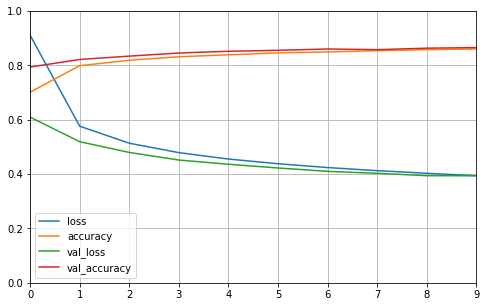

In [10]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()

plot_learning_curves(history)

In [11]:
model.evaluate(x_test, y_test)

   32/10000 [..............................] - ETA: 0s - loss: 38.1014 - accuracy: 0.7188

  448/10000 [>.............................] - ETA: 1s - loss: 29.5467 - accuracy: 0.7210

  768/10000 [=>............................] - ETA: 1s - loss: 34.0715 - accuracy: 0.7044

  960/10000 [=>............................] - ETA: 1s - loss: 35.4252 - accuracy: 0.7063

 1280/10000 [==>...........................] - ETA: 1s - loss: 35.5667 - accuracy: 0.6969

 1664/10000 [===>..........................] - ETA: 1s - loss: 35.0139 - accuracy: 0.6959

 2528/10000 [======>.......................] - ETA: 0s - loss: 34.7824 - accuracy: 0.6998

 3168/10000 [========>.....................] - ETA: 0s - loss: 36.4569 - accuracy: 0.6897

 3904/10000 [==========>...................] - ETA: 0s - loss: 37.8828 - accuracy: 0.6834

 4544/10000 [============>.................] - ETA: 0s - loss: 37.7904 - accuracy: 0.6860

 5184/10000 [==============>...............] - ETA: 0s - loss: 38.2453 - accuracy: 0.6852

 5984/10000 [================>.............] - ETA: 0s - loss: 38.9747 - accuracy: 0.6860

 6816/10000 [===================>..........] - ETA: 0s - loss: 39.3104 - accuracy: 0.6857

 7296/10000 [====================>.........] - ETA: 0s - loss: 39.2553 - accuracy: 0.6848

 7904/10000 [======================>.......] - ETA: 0s - loss: 39.3405 - accuracy: 0.6848

 8128/10000 [=======================>......] - ETA: 0s - loss: 39.3864 - accuracy: 0.6845



 8576/10000 [========================>.....] - ETA: 0s - loss: 39.4026 - accuracy: 0.6851

 8992/10000 [=========================>....] - ETA: 0s - loss: 39.4155 - accuracy: 0.6843

 9536/10000 [===========================>..] - ETA: 0s - loss: 39.5730 - accuracy: 0.6836



10000/10000 [==============================] - 1s 97us/sample - loss: 39.2712 - accuracy: 0.6847


[39.271194969177245, 0.6847]